Here a Sobol Sensitivity Analysis is performed on different versions of the corona simlulation model whilst using the functions from utils_SA.py. 

TODO: This notebook replaces (-> to be deleted later)
- SA_Secir_six_age groups
- examples_SA_Secir_six_age_groups

In [1]:
import memilio.simulation.secir as secir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, date
import time
import seaborn as sns
plt.style.use("seaborn")


In [2]:
from utils_SA import simulate_model, generate_output_daywise

In [3]:
# openturns libraries

from __future__ import print_function
import openturns as ot
import openturns.viewer as viewer
from matplotlib import pylab as plt
ot.Log.Show(ot.Log.NONE)

In [4]:
from pandas.plotting import parallel_coordinates

In [5]:
%config Completer.use_jedi = False

In [6]:
# TODO: move to utils
# define static parameters of the model

# Define Comartment names
compartments = ['Susceptible', 'Exposed', 'Carrier', 'Infected', 'Hospitalized', 'ICU', 'Recovered', 'Dead']
# Define age Groups
groups = ['0-4', '5-14', '15-34', '35-59', '60-79', '80+']
# Define population of age groups
populations = [40000, 70000, 190000, 290000, 180000, 60000] 

days = 100 # number of days to simulate
start_day = 1
start_month = 1
start_year = 2019
starting_day = (date(start_year, start_month, start_day) - date(start_year, 1, 1)).days
dt = 0.1
num_groups = len(groups)
num_compartments = len(compartments)

# set contact frequency matrix
baseline_contact_matrix0 = "../../data/contacts/baseline_home.txt"
baseline_contact_matrix1 = "../../data/contacts/baseline_school_pf_eig.txt"
baseline_contact_matrix2 = "../../data/contacts/baseline_work.txt"
baseline_contact_matrix3 = "../../data/contacts/baseline_other.txt"

baseline_contact_matrix = np.loadtxt(baseline_contact_matrix0) \
        + np.loadtxt(baseline_contact_matrix1) \
        + np.loadtxt(baseline_contact_matrix2) + np.loadtxt(baseline_contact_matrix3)

minimum_contact_matrix = np.ones((num_groups, num_groups)) * 0

In [7]:
static_params = {
    'num_groups': num_groups, 
    'num_compartments': num_compartments,
    'populations': populations,
    'start_day' : (date(start_year, start_month, start_day) - date(start_year, 1, 1)).days,
    'baseline_contact_matrix' : baseline_contact_matrix, 
    'minimum_contact_matrix' : minimum_contact_matrix,
    'damping_coeff' : 0.9, 
    'days' : days,
    'dt' : dt,
    # which compartment's value should be outputed?
    'output_index' : [compartments.index("Infected")]
}


In [8]:
# define input factors and their distributions
# TODO define "incubation_time" and "serial_interval" later
# todo max_rist_of_infection_from symptomatic -> twice rist_of_infection...

comp_transition_duration = [ 
    "infectious_mild_time",   
    "hospitalized_to_home_time", 
    "home_to_hospitalized_time",
    "hospitalized_to_icu_time", 
    "icu_to_home_time", 
    "icu_to_death_time"
]

initial_numbers_comp = [
    "init_exposed", 
    "init_carrier", 
    "init_infected", 
    "init_hospitalized", 
    "init_ICU", 
    "init_recovered",
    "init_dead"
]

comp_transition_probabilities = [
    "relative_carrier_infectability", 
    "infection_probability_from_contact", 
    "asymptotic_cases_per_infectious", 
    "risk_of_infection_from_symptomatic",
    "hospitalized_cases_per_infectious", 
    "ICU_cases_per_hospitalized",
    "deaths_per_hospitalized", 
    "max_risk_of_infection_from_symptomatic"
]


dist_comp_transition_duration = [ 
    ot.Uniform(3, 7),
    ot.Uniform(1, 15),
    ot.Uniform(1, 15),
    ot.Uniform(1, 15),
    ot.Uniform(1, 15),
    ot.Uniform(1, 15)
]
"""
ot.Uniform(3, 7),
ot.Uniform(5, 14),
ot.Uniform(3, 11),
ot.Uniform(1, 7),
ot.Uniform(5, 10),
ot.Uniform(1, 7)
"""
dist_initial_numbers_comp = [
    ot.Uniform(50, 150),
    ot.Uniform(25, 75),
    ot.Uniform(10, 30),
    ot.Uniform(10, 30),
    ot.Uniform(0, 20),
    ot.Uniform(0, 20),
    ot.Uniform(0, 1)
]

dist_comp_transition_probabilities = [
    ot.Uniform(0.1, 0.9),
    ot.Uniform(0.6, 1.0),
    ot.Uniform(0.05, 0.5),
    ot.Uniform(0.01, 0.16),
    ot.Uniform(0.1, 0.35),
    ot.Uniform(0.15, 0.4),
    ot.Uniform(0.15, 0.77),
    ot.Uniform(1, 3) #factor by which risk_of_infection_from_symptomatic gets multiplied
]


input_factor_names = comp_transition_duration + initial_numbers_comp + comp_transition_probabilities
coll = dist_comp_transition_duration + dist_initial_numbers_comp + dist_comp_transition_probabilities

dimension = len(input_factor_names)

In [42]:
comp_transition_duration_ages = [s + "_" + str(i) for s in comp_transition_duration for i in groups]
comp_transition_duration_ages

['infectious_mild_time_0-4',
 'infectious_mild_time_5-14',
 'infectious_mild_time_15-34',
 'infectious_mild_time_35-59',
 'infectious_mild_time_60-79',
 'infectious_mild_time_80+',
 'hospitalized_to_home_time_0-4',
 'hospitalized_to_home_time_5-14',
 'hospitalized_to_home_time_15-34',
 'hospitalized_to_home_time_35-59',
 'hospitalized_to_home_time_60-79',
 'hospitalized_to_home_time_80+',
 'home_to_hospitalized_time_0-4',
 'home_to_hospitalized_time_5-14',
 'home_to_hospitalized_time_15-34',
 'home_to_hospitalized_time_35-59',
 'home_to_hospitalized_time_60-79',
 'home_to_hospitalized_time_80+',
 'hospitalized_to_icu_time_0-4',
 'hospitalized_to_icu_time_5-14',
 'hospitalized_to_icu_time_15-34',
 'hospitalized_to_icu_time_35-59',
 'hospitalized_to_icu_time_60-79',
 'hospitalized_to_icu_time_80+',
 'icu_to_home_time_0-4',
 'icu_to_home_time_5-14',
 'icu_to_home_time_15-34',
 'icu_to_home_time_35-59',
 'icu_to_home_time_60-79',
 'icu_to_home_time_80+',
 'icu_to_death_time_0-4',
 'icu_to_

In [9]:
inputDistribution = ot.ComposedDistribution(coll)
inputDistribution.setDescription(input_factor_names)

size = 1000 

sie = ot.SobolIndicesExperiment(inputDistribution, size)

# generate samples from the input distribution
inputDesign = sie.generate()
input_names = inputDistribution.getDescription()
inputDesign.setDescription(input_factor_names)

print("Sample size: ", inputDesign.getSize())

Sample size:  23000


In [47]:
print(coll[0].getRange())
inputArray = np.array(inputDesign)
inputArray.shape

[3, 7]


21

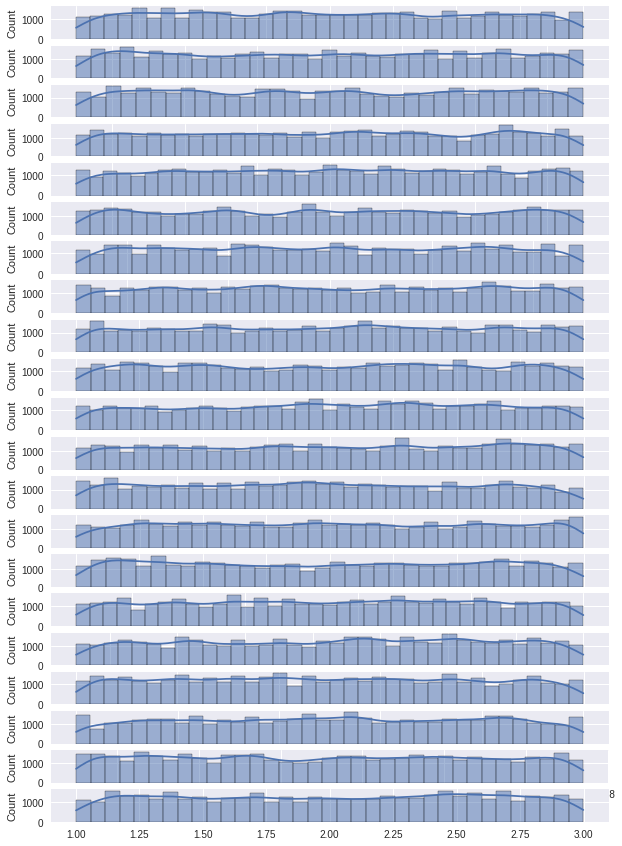

In [57]:
n = len(coll)
fig, axes = plt.subplots(n, 1, figsize=(10, 15))
inputArray = np.array(inputDesign)

for i in range(n):
    sns.histplot(inputArray[:, i], ax = axes[i], kde = True)

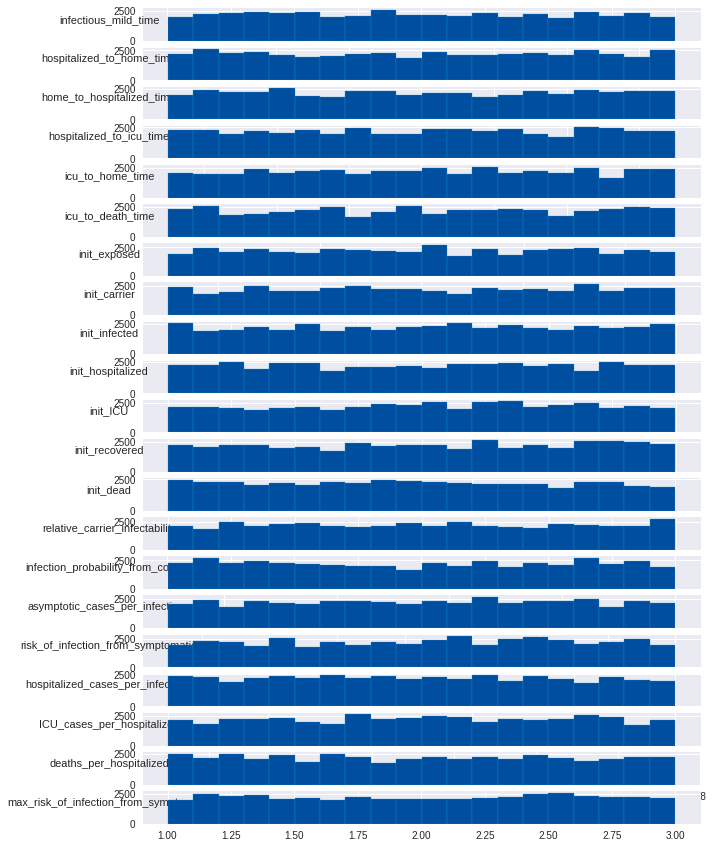

In [62]:
n = len(coll)
n_bins = 20
fig, axes = plt.subplots(n, 1, figsize=(10, 15))
inputArray = np.array(inputDesign)

for i in range(n):
    axes[i].hist(inputArray[:, i], bins = n_bins, facecolor = '#004e9f', edgecolor = '#169acf')
    axes[i].set_ylabel(input_factor_names[i], rotation = 0, font)

# Test interpolated output

In [10]:
static_params["output_operation"]="max"
static_params["output_index"] = [compartments.index("Dead")]

def dict_generate_output_daywise(inputDesign, input_factor_names = input_factor_names, static_params = static_params):
    # how many timepoints does the integration return?
    output = np.zeros((len(inputDesign), static_params["days"]+1))
    
    print("Output ", output.size)
    print()
    
    for i in range(len(inputDesign)):
        result = simulate_model({**dict(zip(input_factor_names, inputDesign[i])), **static_params})
        output[i] = result.T
        if i < 50:
            print(i)

    return output

In [15]:
#start = time.time()
#for i in np.arange(0, 100, 1):
    #p = {**dict(zip(input_factor_names, inputDesign[i])), **static_params}
    #simulate_model(p)
#end = time.time()

In [16]:
start = time.time()
outputDesign = ot.Sample(generate_output_daywise(inputDesign, input_factor_names, static_params))
end = time.time()

[2022-07-05 11:26:26.448] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.452] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.454] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.457] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.460] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.463] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.466] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.468] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.471] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.474] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.477] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.480] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.482] [info] Adaptiv

[2022-07-05 11:26:26.933] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.936] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.939] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.942] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.945] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.948] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.950] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.953] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.955] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.958] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.961] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.963] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:26.966] [info] Adaptiv

[2022-07-05 11:26:27.390] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.393] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.396] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.401] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.406] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.410] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.413] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.415] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.418] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.421] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.423] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.426] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.428] [info] Adaptiv

[2022-07-05 11:26:27.939] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.942] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.944] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.947] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.949] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.952] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.954] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.956] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.959] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.961] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.963] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.966] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:27.968] [info] Adaptiv

[2022-07-05 11:26:28.398] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.401] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.404] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.407] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.409] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.412] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.415] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.418] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.420] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.423] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.425] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.428] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.430] [info] Adaptiv

[2022-07-05 11:26:28.683] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.686] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.689] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.691] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.694] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.696] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.699] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.701] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.704] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.706] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.709] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.711] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:28.713] [info] Adaptiv

[2022-07-05 11:26:29.141] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.143] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.146] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.148] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.150] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.153] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.155] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.158] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.161] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.163] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.166] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.168] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.170] [info] Adaptiv

[2022-07-05 11:26:29.604] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.606] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.609] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.611] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.613] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.615] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.618] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.620] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.623] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.625] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.628] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.630] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:29.633] [info] Adaptiv

[2022-07-05 11:26:30.080] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.082] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.084] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.087] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.089] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.092] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.095] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.097] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.099] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.102] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.104] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.107] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.109] [info] Adaptiv

[2022-07-05 11:26:30.346] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.348] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.350] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.353] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.356] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.359] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.361] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.363] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.366] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.368] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.371] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.373] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.376] [info] Adaptiv

[2022-07-05 11:26:30.783] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.786] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.788] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.790] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.792] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.794] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.797] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.799] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.801] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.804] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.806] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.808] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:30.810] [info] Adaptiv

[2022-07-05 11:26:31.300] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.302] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.304] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.307] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.309] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.312] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.314] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.317] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.320] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.322] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.324] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.327] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.329] [info] Adaptiv

[2022-07-05 11:26:31.742] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.745] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.747] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.750] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.752] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.755] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.758] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.760] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.762] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.765] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.768] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.770] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:31.773] [info] Adaptiv

[2022-07-05 11:26:32.223] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.226] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.227] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.230] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.232] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.235] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.237] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.240] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.242] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.244] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.247] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.249] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.251] [info] Adaptiv

[2022-07-05 11:26:32.474] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.476] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.478] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.480] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.482] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.484] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.487] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.490] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.494] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.497] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.500] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.502] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.504] [info] Adaptiv

[2022-07-05 11:26:32.924] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.927] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.931] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.934] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.937] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.939] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.941] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.944] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.946] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.949] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.952] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.954] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:32.956] [info] Adaptiv

[2022-07-05 11:26:33.530] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:33.534] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:33.539] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:33.543] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:33.546] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:33.548] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:33.551] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:33.554] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:33.556] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:33.559] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:33.562] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:33.565] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:33.568] [info] Adaptiv

[2022-07-05 11:26:34.002] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.007] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.010] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.013] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.016] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.019] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.022] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.024] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.027] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.030] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.033] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.036] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.039] [info] Adaptiv

[2022-07-05 11:26:34.479] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.481] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.483] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.486] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.489] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.493] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.497] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.500] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.502] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.505] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.508] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.510] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.513] [info] Adaptiv

[2022-07-05 11:26:34.943] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.945] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.947] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.949] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.951] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.953] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.956] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.959] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.961] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.963] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.966] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.968] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:34.970] [info] Adaptiv

[2022-07-05 11:26:35.447] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.450] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.452] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.454] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.457] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.460] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.462] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.465] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.467] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.470] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.472] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.474] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.477] [info] Adaptiv

[2022-07-05 11:26:35.814] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.816] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.819] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.821] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.823] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.826] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.828] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.830] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.833] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.835] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.837] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.839] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:35.842] [info] Adaptiv

[2022-07-05 11:26:36.099] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.102] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.104] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.107] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.110] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.113] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.115] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.118] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.120] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.123] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.126] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.129] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.131] [info] Adaptiv

[2022-07-05 11:26:36.388] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.391] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.393] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.397] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.400] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.402] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.405] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.407] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.410] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.413] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.416] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.419] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.422] [info] Adaptiv

[2022-07-05 11:26:36.904] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.907] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.909] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.912] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.915] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.917] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.920] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.922] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.924] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.927] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.929] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.932] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:36.934] [info] Adaptiv

[2022-07-05 11:26:37.294] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.296] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.299] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.301] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.303] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.306] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.308] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.311] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.313] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.316] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.318] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.321] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.323] [info] Adaptiv

[2022-07-05 11:26:37.837] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.839] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.842] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.845] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.848] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.851] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.854] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.857] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.859] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.862] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.864] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.867] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:37.870] [info] Adaptiv

[2022-07-05 11:26:38.270] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.272] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.274] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.277] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.280] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.282] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.285] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.287] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.289] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.291] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.294] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.296] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.298] [info] Adaptiv

[2022-07-05 11:26:38.749] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.751] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.754] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.756] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.759] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.761] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.763] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.765] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.767] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.770] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.772] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.775] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:38.777] [info] Adaptiv

[2022-07-05 11:26:39.179] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.183] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.185] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.188] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.190] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.192] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.195] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.197] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.200] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.203] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.205] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.207] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.210] [info] Adaptiv

[2022-07-05 11:26:39.425] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.427] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.430] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.433] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.435] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.438] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.440] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.443] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.446] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.449] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.451] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.453] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.456] [info] Adaptiv

[2022-07-05 11:26:39.884] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.887] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.889] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.891] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.893] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.896] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.898] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.900] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.903] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.905] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.907] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.909] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:39.912] [info] Adaptiv

[2022-07-05 11:26:40.160] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.163] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.165] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.167] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.170] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.172] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.175] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.177] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.179] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.182] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.186] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.188] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.191] [info] Adaptiv

[2022-07-05 11:26:40.606] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.609] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.611] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.613] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.615] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.618] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.620] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.625] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.630] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.633] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.636] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.638] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.641] [info] Adaptiv

[2022-07-05 11:26:40.860] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.862] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.865] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.867] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.870] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.872] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.875] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.877] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.880] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.882] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.885] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.887] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:40.889] [info] Adaptiv

[2022-07-05 11:26:41.307] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.309] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.312] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.314] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.317] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.320] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.322] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.324] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.326] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.329] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.331] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.333] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.336] [info] Adaptiv

[2022-07-05 11:26:41.576] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.579] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.581] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.584] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.586] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.589] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.592] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.594] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.597] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.599] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.602] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.605] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.607] [info] Adaptiv

[2022-07-05 11:26:41.844] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.846] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.848] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.851] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.853] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.856] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.859] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.861] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.864] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.866] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.868] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.871] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:41.873] [info] Adaptiv

[2022-07-05 11:26:42.306] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.308] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.311] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.314] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.316] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.319] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.322] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.325] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.328] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.330] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.333] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.336] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.338] [info] Adaptiv

[2022-07-05 11:26:42.766] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.768] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.771] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.775] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.778] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.781] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.783] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.786] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.789] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.792] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.794] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.797] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:42.800] [info] Adaptiv

[2022-07-05 11:26:43.245] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.248] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.250] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.253] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.256] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.259] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.262] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.264] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.267] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.270] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.273] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.276] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.279] [info] Adaptiv

[2022-07-05 11:26:43.683] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.685] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.688] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.690] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.693] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.695] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.698] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.700] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.703] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.705] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.710] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.712] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:43.714] [info] Adaptiv

[2022-07-05 11:26:44.107] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.112] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.118] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.123] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.129] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.132] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.136] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.139] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.141] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.144] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.147] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.149] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.152] [info] Adaptiv

[2022-07-05 11:26:44.565] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.568] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.570] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.573] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.576] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.580] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.583] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.585] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.588] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.591] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.594] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.597] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:44.600] [info] Adaptiv

[2022-07-05 11:26:45.003] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.007] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.012] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.015] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.019] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.023] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.027] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.032] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.036] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.038] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.041] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.043] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.046] [info] Adaptiv

[2022-07-05 11:26:45.523] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.526] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.531] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.535] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.539] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.541] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.544] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.548] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.551] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.553] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.556] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.559] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.561] [info] Adaptiv

[2022-07-05 11:26:45.951] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.953] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.955] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.957] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.960] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.962] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.965] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.967] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.970] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.972] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.975] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.977] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:45.979] [info] Adaptiv

[2022-07-05 11:26:46.207] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.210] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.212] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.214] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.217] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.220] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.222] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.225] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.227] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.229] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.231] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.234] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.236] [info] Adaptiv

[2022-07-05 11:26:46.649] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.652] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.654] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.656] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.658] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.661] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.664] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.666] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.668] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.670] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.673] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.676] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.678] [info] Adaptiv

[2022-07-05 11:26:46.902] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.904] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.907] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.909] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.912] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.914] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.917] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.919] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.921] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.924] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.926] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.929] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:46.931] [info] Adaptiv

[2022-07-05 11:26:47.351] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.354] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.356] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.358] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.361] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.364] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.366] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.369] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.372] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.375] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.377] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.380] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.383] [info] Adaptiv

[2022-07-05 11:26:47.634] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.637] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.640] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.643] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.646] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.649] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.651] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.654] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.657] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.659] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.662] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.665] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:47.667] [info] Adaptiv

[2022-07-05 11:26:48.112] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.118] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.123] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.127] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.129] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.131] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.134] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.137] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.139] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.142] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.144] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.147] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.149] [info] Adaptiv

[2022-07-05 11:26:48.372] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.374] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.376] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.378] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.381] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.383] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.385] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.387] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.390] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.392] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.395] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.397] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.400] [info] Adaptiv

[2022-07-05 11:26:48.669] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.671] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.674] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.676] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.679] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.681] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.684] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.686] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.689] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.691] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.693] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.696] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:48.698] [info] Adaptiv

[2022-07-05 11:26:49.120] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.122] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.124] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.127] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.129] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.132] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.134] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.136] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.139] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.142] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.144] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.146] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.149] [info] Adaptiv

[2022-07-05 11:26:49.368] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.370] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.372] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.374] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.377] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.379] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.382] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.384] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.386] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.389] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.391] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.393] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.396] [info] Adaptiv

[2022-07-05 11:26:49.630] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.633] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.635] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.638] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.640] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.643] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.645] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.647] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.650] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.652] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.655] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.657] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:49.659] [info] Adaptiv

[2022-07-05 11:26:50.155] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.158] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.160] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.163] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.165] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.167] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.169] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.172] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.174] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.176] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.179] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.181] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.183] [info] Adaptiv

[2022-07-05 11:26:50.601] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.603] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.605] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.607] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.611] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.613] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.616] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.618] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.620] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.623] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.625] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.628] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.630] [info] Adaptiv

[2022-07-05 11:26:50.859] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.862] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.864] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.866] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.869] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.871] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.873] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.875] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.877] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.880] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.882] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.885] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:50.888] [info] Adaptiv

[2022-07-05 11:26:51.361] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.363] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.365] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.368] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.370] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.373] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.375] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.378] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.380] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.382] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.385] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.387] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.390] [info] Adaptiv

[2022-07-05 11:26:51.798] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.801] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.803] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.806] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.808] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.811] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.814] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.816] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.819] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.821] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.824] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.827] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:51.830] [info] Adaptiv

[2022-07-05 11:26:52.131] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.134] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.137] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.140] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.143] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.146] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.149] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.153] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.155] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.158] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.162] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.164] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.167] [info] Adaptiv

[2022-07-05 11:26:52.435] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.437] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.440] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.443] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.445] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.448] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.450] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.454] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.457] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.460] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.462] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.465] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:52.468] [info] Adaptiv

[2022-07-05 11:26:53.028] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.034] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.040] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.043] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.046] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.049] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.052] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.054] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.057] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.059] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.062] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.065] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.067] [info] Adaptiv

[2022-07-05 11:26:53.558] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.562] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.566] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.569] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.572] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.575] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.578] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.580] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.583] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.586] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.589] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.592] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:53.595] [info] Adaptiv

[2022-07-05 11:26:54.057] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.060] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.063] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.066] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.070] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.073] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.076] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.078] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.081] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.084] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.086] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.089] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.091] [info] Adaptiv

[2022-07-05 11:26:54.529] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.532] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.535] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.538] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.541] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.543] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.545] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.548] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.551] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.553] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.556] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.558] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.561] [info] Adaptiv

[2022-07-05 11:26:54.848] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.850] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.853] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.855] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.857] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.860] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.862] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.865] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.867] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.869] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.871] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.873] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:54.876] [info] Adaptiv

[2022-07-05 11:26:55.289] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.291] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.294] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.295] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.298] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.300] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.302] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.305] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.308] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.310] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.312] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.315] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.317] [info] Adaptiv

[2022-07-05 11:26:55.618] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.621] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.623] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.625] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.627] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.630] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.632] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.634] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.637] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.639] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.641] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.643] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:55.645] [info] Adaptiv

[2022-07-05 11:26:55.995] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.000] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.004] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.006] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.009] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.012] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.015] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.017] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.020] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.023] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.026] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.029] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.032] [info] Adaptiv

[2022-07-05 11:26:56.443] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.446] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.448] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.451] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.453] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.455] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.458] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.461] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.463] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.466] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.468] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.470] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.473] [info] Adaptiv

[2022-07-05 11:26:56.918] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.920] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.922] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.925] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.927] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.929] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.932] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.934] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.937] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.940] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.943] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.945] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:56.948] [info] Adaptiv

[2022-07-05 11:26:57.381] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.384] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.387] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.389] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.391] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.394] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.396] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.398] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.401] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.403] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.405] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.408] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.411] [info] Adaptiv

[2022-07-05 11:26:57.845] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.847] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.849] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.852] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.855] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.857] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.859] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.862] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.865] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.867] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.869] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.871] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:57.873] [info] Adaptiv

[2022-07-05 11:26:58.293] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.295] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.298] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.300] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.303] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.306] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.308] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.311] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.313] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.316] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.318] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.321] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.323] [info] Adaptiv

[2022-07-05 11:26:58.772] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.775] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.777] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.779] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.782] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.784] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.787] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.789] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.792] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.794] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.797] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.799] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:58.802] [info] Adaptiv

[2022-07-05 11:26:59.253] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.255] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.257] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.259] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.262] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.264] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.266] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.269] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.271] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.274] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.276] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.278] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.282] [info] Adaptiv

[2022-07-05 11:26:59.505] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.507] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.510] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.513] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.515] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.518] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.520] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.523] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.525] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.528] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.530] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.533] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.535] [info] Adaptiv

[2022-07-05 11:26:59.763] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.765] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.768] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.770] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.773] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.775] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.777] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.780] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.783] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.785] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.787] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.789] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:26:59.791] [info] Adaptiv

[2022-07-05 11:27:00.187] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.190] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.192] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.194] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.196] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.199] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.201] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.204] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.207] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.210] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.212] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.215] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.217] [info] Adaptiv

[2022-07-05 11:27:00.464] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.466] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.469] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.471] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.473] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.476] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.478] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.481] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.483] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.485] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.487] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.490] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.493] [info] Adaptiv

[2022-07-05 11:27:00.729] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.731] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.733] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.736] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.738] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.739] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.742] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.745] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.747] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.749] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.752] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.754] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:00.756] [info] Adaptiv

[2022-07-05 11:27:01.212] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.214] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.216] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.219] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.221] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.224] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.226] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.228] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.231] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.233] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.236] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.239] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.243] [info] Adaptiv

[2022-07-05 11:27:01.676] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.678] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.680] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.683] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.685] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.688] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.691] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.693] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.695] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.697] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.699] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.702] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:01.704] [info] Adaptiv

[2022-07-05 11:27:02.152] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.155] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.158] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.163] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.167] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.170] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.173] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.176] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.178] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.181] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.184] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.186] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.189] [info] Adaptiv

[2022-07-05 11:27:02.633] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.637] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.639] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.642] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.645] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.647] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.650] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.653] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.656] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.658] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.661] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.664] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:02.666] [info] Adaptiv

[2022-07-05 11:27:03.113] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.117] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.119] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.122] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.125] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.128] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.130] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.133] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.136] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.138] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.141] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.144] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.146] [info] Adaptiv

[2022-07-05 11:27:03.402] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.404] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.407] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.409] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.412] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.415] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.417] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.420] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.423] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.426] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.428] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.431] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.433] [info] Adaptiv

[2022-07-05 11:27:03.902] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.904] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.907] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.911] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.913] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.916] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.919] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.921] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.924] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.926] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.928] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.930] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:03.933] [info] Adaptiv

[2022-07-05 11:27:04.151] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.154] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.157] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.160] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.162] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.165] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.167] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.170] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.172] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.175] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.177] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.180] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.183] [info] Adaptiv

[2022-07-05 11:27:04.589] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.591] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.594] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.597] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.600] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.603] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.605] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.607] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.610] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.612] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.614] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.617] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:04.619] [info] Adaptiv

[2022-07-05 11:27:05.034] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.041] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.047] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.053] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.059] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.064] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.066] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.069] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.072] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.075] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.078] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.081] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.084] [info] Adaptiv

[2022-07-05 11:27:05.508] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.512] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.515] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.518] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.520] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.523] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.526] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.529] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.532] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.536] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.538] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.541] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.543] [info] Adaptiv

[2022-07-05 11:27:05.984] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.987] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.989] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.993] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:05.999] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.004] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.009] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.014] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.020] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.026] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.032] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.038] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.042] [info] Adaptiv

[2022-07-05 11:27:06.328] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.331] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.334] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.336] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.338] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.341] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.343] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.346] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.348] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.351] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.353] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.356] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.358] [info] Adaptiv

[2022-07-05 11:27:06.855] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.857] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.860] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.863] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.866] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.869] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.872] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.875] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.878] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.880] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.883] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.885] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:06.888] [info] Adaptiv

[2022-07-05 11:27:07.506] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:07.511] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:07.516] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:07.521] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:07.524] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:07.526] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:07.529] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:07.532] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:07.534] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:07.537] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:07.539] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:07.542] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:07.545] [info] Adaptiv

[2022-07-05 11:27:08.020] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.022] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.026] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.028] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.030] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.033] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.035] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.037] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.040] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.042] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.044] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.047] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.049] [info] Adaptiv

[2022-07-05 11:27:08.294] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.296] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.298] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.301] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.304] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.306] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.309] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.311] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.313] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.316] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.318] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.321] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.324] [info] Adaptiv

[2022-07-05 11:27:08.738] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.740] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.743] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.746] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.749] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.752] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.754] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.758] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.760] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.763] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.766] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.769] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:08.771] [info] Adaptiv

[2022-07-05 11:27:09.195] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.198] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.201] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.203] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.205] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.208] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.210] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.213] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.215] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.218] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.220] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.222] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.224] [info] Adaptiv

[2022-07-05 11:27:09.639] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.643] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.646] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.650] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.654] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.656] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.659] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.661] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.664] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.666] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.669] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.671] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.674] [info] Adaptiv

[2022-07-05 11:27:09.922] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.925] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.927] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.930] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.932] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.935] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.937] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.939] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.941] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.945] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.947] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.950] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:09.952] [info] Adaptiv

[2022-07-05 11:27:10.391] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.394] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.396] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.398] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.401] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.404] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.406] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.408] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.411] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.414] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.416] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.419] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.421] [info] Adaptiv

[2022-07-05 11:27:10.876] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.878] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.880] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.883] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.885] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.888] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.890] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.893] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.895] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.898] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.900] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.902] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:10.908] [info] Adaptiv

[2022-07-05 11:27:11.356] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.359] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.361] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.364] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.366] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.369] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.371] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.373] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.375] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.378] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.380] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.383] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.385] [info] Adaptiv

[2022-07-05 11:27:11.856] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.859] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.862] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.864] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.867] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.870] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.873] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.876] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.879] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.881] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.884] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.887] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:11.890] [info] Adaptiv

[2022-07-05 11:27:12.355] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.358] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.360] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.362] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.365] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.368] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.370] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.372] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.375] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.378] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.380] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.383] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.386] [info] Adaptiv

[2022-07-05 11:27:12.930] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.933] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.936] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.938] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.940] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.943] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.946] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.948] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.951] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.954] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.956] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.959] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:12.962] [info] Adaptiv

[2022-07-05 11:27:13.445] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.448] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.451] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.453] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.456] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.459] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.461] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.464] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.467] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.470] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.473] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.476] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.478] [info] Adaptiv

[2022-07-05 11:27:13.899] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.902] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.905] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.907] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.910] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.914] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.917] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.919] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.922] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.925] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.928] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.931] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:13.934] [info] Adaptiv

[2022-07-05 11:27:14.366] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.369] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.372] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.375] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.377] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.380] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.383] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.386] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.389] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.391] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.394] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.396] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.399] [info] Adaptiv

[2022-07-05 11:27:14.870] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.873] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.876] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.878] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.881] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.884] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.887] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.890] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.893] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.895] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.898] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.900] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:14.903] [info] Adaptiv

[2022-07-05 11:27:15.328] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.331] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.334] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.336] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.338] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.341] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.343] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.346] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.348] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.351] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.353] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.355] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.358] [info] Adaptiv

[2022-07-05 11:27:15.783] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.786] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.788] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.791] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.793] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.797] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.799] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.802] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.804] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.807] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.810] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.812] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:15.815] [info] Adaptiv

[2022-07-05 11:27:16.279] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.282] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.284] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.287] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.289] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.291] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.294] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.296] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.299] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.302] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.304] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.306] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.309] [info] Adaptiv

[2022-07-05 11:27:16.777] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.780] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.782] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.785] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.787] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.789] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.792] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.795] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.797] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.800] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.803] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.805] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:16.808] [info] Adaptiv

[2022-07-05 11:27:17.233] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.235] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.237] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.239] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.242] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.244] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.247] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.250] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.253] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.255] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.257] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.260] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.262] [info] Adaptiv

[2022-07-05 11:27:17.674] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.679] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.684] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.689] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.695] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.701] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.704] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.706] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.709] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.712] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.715] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.718] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:17.720] [info] Adaptiv

[2022-07-05 11:27:18.203] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.206] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.209] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.212] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.214] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.217] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.220] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.223] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.226] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.229] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.231] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.234] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.237] [info] Adaptiv

[2022-07-05 11:27:18.727] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.730] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.734] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.737] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.740] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.743] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.749] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.752] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.755] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.759] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.762] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.765] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:18.768] [info] Adaptiv

[2022-07-05 11:27:19.179] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.182] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.185] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.188] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.191] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.194] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.197] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.199] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.202] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.205] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.208] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.211] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.214] [info] Adaptiv

[2022-07-05 11:27:19.634] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.637] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.640] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.643] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.647] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.650] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.652] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.655] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.657] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.660] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.663] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.665] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.668] [info] Adaptiv

[2022-07-05 11:27:19.911] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.913] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.916] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.918] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.921] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.924] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.926] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.928] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.931] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.933] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.936] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.938] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:19.941] [info] Adaptiv

[2022-07-05 11:27:20.380] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.383] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.386] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.388] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.391] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.393] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.396] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.399] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.401] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.404] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.407] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.409] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.411] [info] Adaptiv

[2022-07-05 11:27:20.855] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.858] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.860] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.863] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.865] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.869] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.871] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.874] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.876] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.878] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.881] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.884] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:20.886] [info] Adaptiv

[2022-07-05 11:27:21.149] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.152] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.155] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.158] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.160] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.163] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.166] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.169] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.172] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.174] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.177] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.180] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.183] [info] Adaptiv

[2022-07-05 11:27:21.690] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.692] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.695] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.697] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.700] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.702] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.705] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.708] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.710] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.712] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.715] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.717] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:21.720] [info] Adaptiv

[2022-07-05 11:27:22.022] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.026] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.030] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.034] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.038] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.042] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.046] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.049] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.051] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.053] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.056] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.058] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.060] [info] Adaptiv

[2022-07-05 11:27:22.291] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.293] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.296] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.298] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.301] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.303] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.305] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.308] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.311] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.313] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.315] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.318] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.320] [info] Adaptiv

[2022-07-05 11:27:22.753] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.755] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.758] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.760] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.762] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.764] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.767] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.769] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.772] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.775] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.777] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.779] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:22.782] [info] Adaptiv

[2022-07-05 11:27:23.228] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.230] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.233] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.236] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.239] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.242] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.244] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.247] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.250] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.252] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.255] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.258] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.261] [info] Adaptiv

[2022-07-05 11:27:23.707] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.709] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.711] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.714] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.717] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.719] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.722] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.725] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.727] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.730] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.733] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.736] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:23.739] [info] Adaptiv

[2022-07-05 11:27:24.268] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.270] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.273] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.276] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.279] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.281] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.284] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.287] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.289] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.292] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.295] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.297] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.300] [info] Adaptiv

[2022-07-05 11:27:24.686] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.689] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.691] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.694] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.696] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.698] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.701] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.704] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.706] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.709] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.711] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.714] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.716] [info] Adaptiv

[2022-07-05 11:27:24.940] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.943] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.945] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.948] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.950] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.953] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.955] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.958] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.960] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.962] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.965] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.967] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:24.969] [info] Adaptiv

[2022-07-05 11:27:25.366] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.368] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.370] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.373] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.375] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.378] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.380] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.383] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.387] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.390] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.393] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.395] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.398] [info] Adaptiv

[2022-07-05 11:27:25.828] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.830] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.834] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.837] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.840] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.843] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.846] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:27:25.848] [info] Adaptive step sizing successful to tolerances.


In [17]:
print(end-start)

59.42679405212402


In [18]:
#output = np.loadtxt("simulation_output.txt")
#outputDesign = ot.Sample(output)

In [26]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

In [20]:
agg_first_order = sensitivityAnalysis.getAggregatedFirstOrderIndices()
agg_total_order = sensitivityAnalysis.getAggregatedTotalOrderIndices()
print("Agg. first order indices: ", agg_first_order)
print("Agg. total order indices: ", agg_total_order)

Agg. first order indices:  [0.0148706,0.0642793,0.171511,0.0959282,0.0151431,0.0556035,-0.0306606,-0.0321555,-0.031959,-0.0319786,-0.0319555,-0.0319793,-0.0319825,-0.0115729,-0.0281402,-0.0255331,-0.0278479,0.0302504,-0.00164618,0.0450756,-0.0319793]#21
Agg. total order indices:  [0.0494973,0.211461,0.297855,0.270727,0.0528811,0.0735191,-0.00113087,-0.0002006,-8.72466e-05,-1.71049e-06,-5.66366e-05,-9.08175e-06,4.85317e-07,0.0500459,0.00541982,0.0216099,0.00396255,0.0505302,0.0666044,0.127186,-6.35001e-08]#21


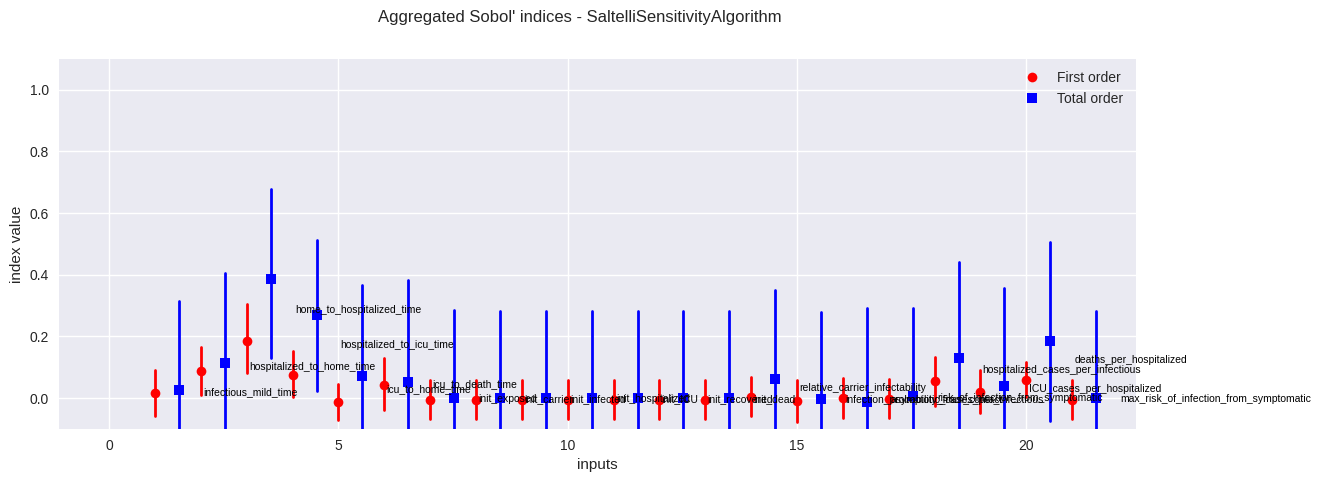

In [36]:
graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1400, 500))

In [28]:
first_order = sensitivityAnalysis.getFirstOrderIndices()
total_order = sensitivityAnalysis.getTotalOrderIndices()
print("First order indices: ", agg_first_order)
print("Total order indices: ", agg_total_order)

First order indices:  [0.0148706,0.0642793,0.171511,0.0959282,0.0151431,0.0556035,-0.0306606,-0.0321555,-0.031959,-0.0319786,-0.0319555,-0.0319793,-0.0319825,-0.0115729,-0.0281402,-0.0255331,-0.0278479,0.0302504,-0.00164618,0.0450756,-0.0319793]#21
Total order indices:  [0.0494973,0.211461,0.297855,0.270727,0.0528811,0.0735191,-0.00113087,-0.0002006,-8.72466e-05,-1.71049e-06,-5.66366e-05,-9.08175e-06,4.85317e-07,0.0500459,0.00541982,0.0216099,0.00396255,0.0505302,0.0666044,0.127186,-6.35001e-08]#21


In [29]:
input_factor_names

['infectious_mild_time',
 'hospitalized_to_home_time',
 'home_to_hospitalized_time',
 'hospitalized_to_icu_time',
 'icu_to_home_time',
 'icu_to_death_time',
 'init_exposed',
 'init_carrier',
 'init_infected',
 'init_hospitalized',
 'init_ICU',
 'init_recovered',
 'init_dead',
 'relative_carrier_infectability',
 'infection_probability_from_contact',
 'asymptotic_cases_per_infectious',
 'risk_of_infection_from_symptomatic',
 'hospitalized_cases_per_infectious',
 'ICU_cases_per_hospitalized',
 'deaths_per_hospitalized',
 'max_risk_of_infection_from_symptomatic']

## Aggregated second Order Indices

In [23]:
size = 1000
computeSecondOrder = True
sie = ot.SobolIndicesExperiment(inputDistribution, size, computeSecondOrder)
inputDesign = sie.generate()
print("Sample size: ", inputDesign.getSize())

static_params["output_operation"] = "None"
static_params["output_index"] = [compartments.index("Dead")]

start = time.time()
outputDesign = ot.Sample(generate_output_daywise(inputDesign, input_factor_names, static_params))
end = time.time()
print(end - start)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

Sample size:  44000
[2022-07-05 11:30:03.230] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.235] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.238] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.240] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.247] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.251] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.254] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.257] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.260] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.262] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.265] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.268] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03

[2022-07-05 11:30:03.688] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.691] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.694] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.696] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.699] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.702] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.704] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.707] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.710] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.713] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.716] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.718] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:03.721] [info] Adaptiv

[2022-07-05 11:30:04.159] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.162] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.165] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.170] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.176] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.178] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.180] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.183] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.185] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.188] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.190] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.192] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.195] [info] Adaptiv

[2022-07-05 11:30:04.660] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.664] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.669] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.673] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.677] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.684] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.690] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.694] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.698] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.701] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.703] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.706] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:04.708] [info] Adaptiv

[2022-07-05 11:30:05.110] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.113] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.116] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.119] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.122] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.124] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.127] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.129] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.132] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.135] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.138] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.140] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.143] [info] Adaptiv

[2022-07-05 11:30:05.557] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.560] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.563] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.566] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.569] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.572] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.575] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.577] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.579] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.582] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.585] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.588] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:05.590] [info] Adaptiv

[2022-07-05 11:30:06.029] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.032] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.035] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.038] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.041] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.043] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.046] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.048] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.051] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.054] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.056] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.059] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.061] [info] Adaptiv

[2022-07-05 11:30:06.476] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.478] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.483] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.487] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.493] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.496] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.498] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.502] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.504] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.507] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.510] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.513] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.516] [info] Adaptiv

[2022-07-05 11:30:06.930] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.933] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.936] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.939] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.942] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.944] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.947] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.950] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.953] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.955] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.958] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.960] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:06.963] [info] Adaptiv

[2022-07-05 11:30:07.416] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.419] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.422] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.426] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.430] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.434] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.436] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.439] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.441] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.444] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.447] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.449] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.451] [info] Adaptiv

[2022-07-05 11:30:07.861] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.863] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.866] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.868] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.871] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.874] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.876] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.879] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.882] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.884] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.887] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.889] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:07.892] [info] Adaptiv

[2022-07-05 11:30:08.286] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.288] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.290] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.293] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.295] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.298] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.300] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.303] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.305] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.308] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.310] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.314] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.318] [info] Adaptiv

[2022-07-05 11:30:08.719] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.722] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.724] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.727] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.730] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.733] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.735] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.738] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.740] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.742] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.745] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.748] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:08.751] [info] Adaptiv

[2022-07-05 11:30:09.175] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.177] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.180] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.183] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.186] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.188] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.191] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.194] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.196] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.199] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.202] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.204] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.207] [info] Adaptiv

[2022-07-05 11:30:09.613] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.616] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.619] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.622] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.625] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.628] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.630] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.633] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.636] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.639] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.642] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.645] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:09.648] [info] Adaptiv

[2022-07-05 11:30:10.068] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.072] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.076] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.079] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.082] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.084] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.086] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.089] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.092] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.094] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.096] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.099] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.102] [info] Adaptiv

[2022-07-05 11:30:10.522] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.526] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.531] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.536] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.539] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.543] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.546] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.548] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.551] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.553] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.555] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.557] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.559] [info] Adaptiv

[2022-07-05 11:30:10.956] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.958] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.961] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.964] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.966] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.968] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.971] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.974] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.976] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.978] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.980] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.983] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:10.985] [info] Adaptiv

[2022-07-05 11:30:11.393] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.395] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.398] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.400] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.402] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.405] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.407] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.409] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.412] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.415] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.418] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.420] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.423] [info] Adaptiv

[2022-07-05 11:30:11.641] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.644] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.646] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.649] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.652] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.654] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.656] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.659] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.661] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.663] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.666] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.669] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:11.671] [info] Adaptiv

[2022-07-05 11:30:12.117] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.122] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.127] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.129] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.132] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.135] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.137] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.140] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.142] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.146] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.150] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.155] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.157] [info] Adaptiv

[2022-07-05 11:30:12.572] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.575] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.578] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.581] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.584] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.587] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.590] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.592] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.596] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.602] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.606] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.609] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:12.611] [info] Adaptiv

[2022-07-05 11:30:13.008] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.011] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.015] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.019] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.021] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.024] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.026] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.029] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.031] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.034] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.036] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.042] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.046] [info] Adaptiv

[2022-07-05 11:30:13.464] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.466] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.469] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.472] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.474] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.477] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.479] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.481] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.484] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.486] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.489] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.492] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.495] [info] Adaptiv

[2022-07-05 11:30:13.910] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.913] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.916] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.919] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.920] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.923] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.925] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.928] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.932] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.937] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.940] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.943] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:13.946] [info] Adaptiv

[2022-07-05 11:30:14.400] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.402] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.405] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.408] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.410] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.413] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.416] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.418] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.421] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.424] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.426] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.429] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.432] [info] Adaptiv

[2022-07-05 11:30:14.869] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.872] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.875] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.878] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.880] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.883] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.885] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.888] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.891] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.893] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.896] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.898] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:14.901] [info] Adaptiv

[2022-07-05 11:30:15.342] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.344] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.347] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.349] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.351] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.354] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.356] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.358] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.361] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.363] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.367] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.371] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.374] [info] Adaptiv

[2022-07-05 11:30:15.766] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.769] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.772] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.774] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.776] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.779] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.781] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.783] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.785] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.787] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.789] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.791] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:15.794] [info] Adaptiv

[2022-07-05 11:30:16.192] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.195] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.198] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.201] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.203] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.206] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.209] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.211] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.214] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.217] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.219] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.222] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.225] [info] Adaptiv

[2022-07-05 11:30:16.674] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.677] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.680] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.683] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.686] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.689] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.692] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.695] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.698] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.701] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.704] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.707] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:16.709] [info] Adaptiv

[2022-07-05 11:30:17.166] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.169] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.172] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.175] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.178] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.181] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.183] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.186] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.189] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.191] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.194] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.196] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.199] [info] Adaptiv

[2022-07-05 11:30:17.430] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.432] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.434] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.437] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.440] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.442] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.445] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.447] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.449] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.451] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.454] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.456] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.458] [info] Adaptiv

[2022-07-05 11:30:17.839] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.841] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.843] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.845] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.847] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.850] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.852] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.854] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.856] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.859] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.861] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.863] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:17.866] [info] Adaptiv

[2022-07-05 11:30:18.307] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.310] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.313] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.315] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.317] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.319] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.321] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.324] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.326] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.328] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.330] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.333] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.335] [info] Adaptiv

[2022-07-05 11:30:18.768] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.770] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.773] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.776] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.778] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.780] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.782] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.785] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.787] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.789] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.791] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.794] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:18.796] [info] Adaptiv

[2022-07-05 11:30:19.223] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.225] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.227] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.230] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.232] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.235] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.237] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.239] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.241] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.244] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.246] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.249] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.251] [info] Adaptiv

[2022-07-05 11:30:19.664] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.666] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.668] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.670] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.674] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.676] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.678] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.681] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.683] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.687] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.691] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.695] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:19.697] [info] Adaptiv

[2022-07-05 11:30:20.097] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.100] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.102] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.105] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.108] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.111] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.114] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.117] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.120] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.125] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.130] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.132] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.134] [info] Adaptiv

[2022-07-05 11:30:20.575] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.577] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.580] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.582] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.584] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.587] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.589] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.592] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.594] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.596] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.599] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.601] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:20.604] [info] Adaptiv

[2022-07-05 11:30:21.019] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.021] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.023] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.026] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.028] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.030] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.032] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.035] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.037] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.039] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.042] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.045] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.047] [info] Adaptiv

[2022-07-05 11:30:21.482] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.484] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.487] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.489] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.494] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.498] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.501] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.503] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.506] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.508] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.511] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.513] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.516] [info] Adaptiv

[2022-07-05 11:30:21.914] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.916] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.919] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.921] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.924] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.927] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.930] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.932] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.935] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.938] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.940] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.942] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:21.945] [info] Adaptiv

[2022-07-05 11:30:22.368] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.370] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.373] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.375] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.377] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.380] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.382] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.385] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.387] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.390] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.392] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.395] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.397] [info] Adaptiv

[2022-07-05 11:30:22.843] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.846] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.848] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.851] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.854] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.856] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.858] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.861] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.863] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.865] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.868] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.870] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:22.872] [info] Adaptiv

[2022-07-05 11:30:23.316] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.319] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.321] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.324] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.326] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.329] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.332] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.335] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.338] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.341] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.343] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.346] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.349] [info] Adaptiv

[2022-07-05 11:30:23.777] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.779] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.782] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.784] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.786] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.789] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.792] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.794] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.796] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.799] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.802] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.804] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:23.806] [info] Adaptiv

[2022-07-05 11:30:24.015] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.017] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.020] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.022] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.025] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.029] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.032] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.036] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.039] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.042] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.044] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.047] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.049] [info] Adaptiv

[2022-07-05 11:30:24.436] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.438] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.441] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.443] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.446] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.449] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.451] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.453] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.458] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.462] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.464] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.467] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.470] [info] Adaptiv

[2022-07-05 11:30:24.885] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.887] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.890] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.892] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.894] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.897] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.900] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.902] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.905] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.908] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.910] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.913] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:24.916] [info] Adaptiv

[2022-07-05 11:30:25.420] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.423] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.425] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.428] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.431] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.434] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.436] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.439] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.441] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.444] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.447] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.449] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.452] [info] Adaptiv

[2022-07-05 11:30:25.894] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.897] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.900] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.903] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.905] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.908] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.912] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.914] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.917] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.920] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.922] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.925] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:25.928] [info] Adaptiv

[2022-07-05 11:30:26.372] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.375] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.378] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.381] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.383] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.386] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.389] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.391] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.394] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.397] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.400] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.402] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.405] [info] Adaptiv

[2022-07-05 11:30:26.863] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.865] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.868] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.871] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.873] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.876] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.879] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.882] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.884] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.887] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.890] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.892] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:26.895] [info] Adaptiv

[2022-07-05 11:30:27.335] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.337] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.340] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.343] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.346] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.349] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.351] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.354] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.356] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.359] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.362] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.365] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.367] [info] Adaptiv

[2022-07-05 11:30:27.819] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.821] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.824] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.826] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.829] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.832] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.835] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.838] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.841] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.843] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.847] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.850] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:27.852] [info] Adaptiv

[2022-07-05 11:30:28.280] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.283] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.286] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.289] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.292] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.294] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.297] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.300] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.302] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.305] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.308] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.310] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.313] [info] Adaptiv

[2022-07-05 11:30:28.728] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.730] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.732] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.734] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.737] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.740] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.742] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.744] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.746] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.749] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.751] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.753] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:28.756] [info] Adaptiv

[2022-07-05 11:30:29.170] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.172] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.175] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.177] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.179] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.182] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.184] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.187] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.189] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.192] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.194] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.196] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.199] [info] Adaptiv

[2022-07-05 11:30:29.609] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.615] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.621] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.626] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.632] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.635] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.638] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.641] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.643] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.646] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.649] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.652] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:29.654] [info] Adaptiv

[2022-07-05 11:30:30.081] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.084] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.087] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.089] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.092] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.095] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.097] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.100] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.102] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.105] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.108] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.110] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.113] [info] Adaptiv

[2022-07-05 11:30:30.538] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.542] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.547] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.550] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.553] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.555] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.558] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.561] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.563] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.566] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.571] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.575] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.579] [info] Adaptiv

[2022-07-05 11:30:30.992] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.995] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.997] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:30.999] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.002] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.004] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.006] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.009] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.011] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.013] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.015] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.018] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.020] [info] Adaptiv

[2022-07-05 11:30:31.465] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.467] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.470] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.472] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.475] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.477] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.479] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.481] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.484] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.486] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.489] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.494] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.496] [info] Adaptiv

[2022-07-05 11:30:31.915] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.918] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.921] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.924] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.927] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.930] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.936] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.941] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.943] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.945] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.948] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.950] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:31.952] [info] Adaptiv

[2022-07-05 11:30:32.353] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.356] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.358] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.361] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.363] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.366] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.368] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.371] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.373] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.376] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.378] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.380] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.383] [info] Adaptiv

[2022-07-05 11:30:32.785] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.787] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.790] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.792] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.794] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.798] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.800] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.805] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.810] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.814] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.817] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.820] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:32.823] [info] Adaptiv

[2022-07-05 11:30:33.264] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.268] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.270] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.273] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.276] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.279] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.282] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.285] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.287] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.291] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.293] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.296] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.299] [info] Adaptiv

[2022-07-05 11:30:33.700] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.703] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.706] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.709] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.712] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.714] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.717] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.720] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.722] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.725] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.727] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.730] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:33.732] [info] Adaptiv

[2022-07-05 11:30:34.159] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.161] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.164] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.167] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.169] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.171] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.174] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.176] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.179] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.181] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.183] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.186] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.189] [info] Adaptiv

[2022-07-05 11:30:34.636] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.640] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.645] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.649] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.652] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.655] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.658] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.660] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.663] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.666] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.669] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.672] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:34.674] [info] Adaptiv

[2022-07-05 11:30:35.089] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.093] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.099] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.103] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.106] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.108] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.111] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.114] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.116] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.119] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.122] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.124] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.127] [info] Adaptiv

[2022-07-05 11:30:35.543] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.546] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.548] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.551] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.554] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.557] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.560] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.562] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.565] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.567] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.570] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.572] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.574] [info] Adaptiv

[2022-07-05 11:30:35.804] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.806] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.809] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.812] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.815] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.818] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.820] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.823] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.825] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.827] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.830] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.832] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:35.834] [info] Adaptiv

[2022-07-05 11:30:36.290] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.293] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.295] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.298] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.300] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.303] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.305] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.308] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.310] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.313] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.315] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.318] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.320] [info] Adaptiv

[2022-07-05 11:30:36.747] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.749] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.752] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.754] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.756] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.759] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.761] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.763] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.766] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.768] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.771] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.773] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:36.775] [info] Adaptiv

[2022-07-05 11:30:37.190] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.193] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.195] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.198] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.200] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.203] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.205] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.207] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.209] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.212] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.214] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.217] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.219] [info] Adaptiv

[2022-07-05 11:30:37.626] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.628] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.631] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.633] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.635] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.638] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.640] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.642] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.645] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.647] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.649] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.652] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:37.654] [info] Adaptiv

[2022-07-05 11:30:38.073] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.075] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.077] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.080] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.082] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.084] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.087] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.090] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.092] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.095] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.097] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.100] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.102] [info] Adaptiv

[2022-07-05 11:30:38.519] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.523] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.526] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.530] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.533] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.536] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.538] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.541] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.543] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.546] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.548] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.550] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.553] [info] Adaptiv

[2022-07-05 11:30:38.957] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.959] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.961] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.963] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.966] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.968] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.971] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.973] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.976] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.978] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.980] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.982] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:38.984] [info] Adaptiv

[2022-07-05 11:30:39.386] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.389] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.391] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.394] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.397] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.399] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.401] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.404] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.406] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.408] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.411] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.413] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.415] [info] Adaptiv

[2022-07-05 11:30:39.636] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.639] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.641] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.644] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.646] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.649] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.651] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.653] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.656] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.658] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.661] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.663] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:39.666] [info] Adaptiv

[2022-07-05 11:30:40.063] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.066] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.068] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.071] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.073] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.075] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.078] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.080] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.082] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.085] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.087] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.089] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.092] [info] Adaptiv

[2022-07-05 11:30:40.501] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.504] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.506] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.509] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.511] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.513] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.516] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.518] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.521] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.523] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.525] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.527] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.530] [info] Adaptiv

[2022-07-05 11:30:40.739] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.742] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.745] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.746] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.749] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.751] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.754] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.756] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.758] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.761] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.763] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.765] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:40.768] [info] Adaptiv

[2022-07-05 11:30:41.152] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.157] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.163] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.168] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.174] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.179] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.184] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.187] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.190] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.193] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.198] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.201] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.204] [info] Adaptiv

[2022-07-05 11:30:41.625] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.627] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.630] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.632] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.634] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.637] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.639] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.641] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.644] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.646] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.649] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.651] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:41.653] [info] Adaptiv

[2022-07-05 11:30:42.056] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.059] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.062] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.064] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.067] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.069] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.072] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.074] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.077] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.079] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.082] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.084] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.087] [info] Adaptiv

[2022-07-05 11:30:42.527] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.529] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.532] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.534] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.536] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.539] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.541] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.543] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.546] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.548] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.551] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.553] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:42.555] [info] Adaptiv

[2022-07-05 11:30:43.013] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.018] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.024] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.030] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.032] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.034] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.037] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.040] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.042] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.045] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.047] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.049] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.052] [info] Adaptiv

[2022-07-05 11:30:43.281] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.283] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.286] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.288] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.291] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.293] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.295] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.298] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.300] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.302] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.305] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.307] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.309] [info] Adaptiv

[2022-07-05 11:30:43.758] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.760] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.763] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.765] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.768] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.770] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.773] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.776] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.778] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.780] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.782] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.785] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:43.787] [info] Adaptiv

[2022-07-05 11:30:44.184] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.186] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.188] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.190] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.192] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.194] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.197] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.199] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.201] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.204] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.206] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.208] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.210] [info] Adaptiv

[2022-07-05 11:30:44.418] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.421] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.423] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.426] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.428] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.430] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.432] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.435] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.437] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.439] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.442] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.444] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.447] [info] Adaptiv

[2022-07-05 11:30:44.890] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.893] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.895] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.897] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.900] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.902] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.904] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.906] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.909] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.911] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.913] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.916] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:44.918] [info] Adaptiv

[2022-07-05 11:30:45.323] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.325] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.327] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.330] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.334] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.336] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.339] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.342] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.344] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.347] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.350] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.353] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.355] [info] Adaptiv

[2022-07-05 11:30:45.777] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.780] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.782] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.785] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.787] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.790] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.792] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.794] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.797] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.799] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.801] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.804] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:45.806] [info] Adaptiv

[2022-07-05 11:30:46.227] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.229] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.231] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.234] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.236] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.239] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.242] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.244] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.246] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.249] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.251] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.254] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.256] [info] Adaptiv

[2022-07-05 11:30:46.669] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.671] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.674] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.677] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.680] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.683] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.686] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.688] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.691] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.694] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.697] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.699] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:46.702] [info] Adaptiv

[2022-07-05 11:30:47.173] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.178] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.184] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.187] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.190] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.193] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.195] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.198] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.200] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.202] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.205] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.207] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.209] [info] Adaptiv

[2022-07-05 11:30:47.616] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.618] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.620] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.622] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.625] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.628] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.630] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.633] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.635] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.637] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.639] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.642] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.644] [info] Adaptiv

[2022-07-05 11:30:47.861] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.864] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.866] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.869] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.871] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.874] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.876] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.878] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.881] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.883] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.886] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.888] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:47.891] [info] Adaptiv

[2022-07-05 11:30:48.345] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.348] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.350] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.355] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.357] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.360] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.362] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.365] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.367] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.370] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.373] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.375] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.378] [info] Adaptiv

[2022-07-05 11:30:48.781] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.783] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.786] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.789] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.792] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.794] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.797] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.799] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.802] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.805] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.807] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.810] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:48.813] [info] Adaptiv

[2022-07-05 11:30:49.313] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.315] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.318] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.322] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.324] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.326] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.329] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.332] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.334] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.337] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.339] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.342] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.344] [info] Adaptiv

[2022-07-05 11:30:49.738] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.741] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.743] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.746] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.748] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.751] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.754] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.757] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.760] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.762] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.765] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.768] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:49.770] [info] Adaptiv

[2022-07-05 11:30:50.227] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.229] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.232] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.234] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.237] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.239] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.242] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.244] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.247] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.249] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.251] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.254] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.256] [info] Adaptiv

[2022-07-05 11:30:50.489] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.492] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.494] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.497] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.499] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.501] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.504] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.506] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.509] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.512] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.514] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.517] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.519] [info] Adaptiv

[2022-07-05 11:30:50.952] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.954] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.956] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.958] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.961] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.963] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.966] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.968] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.971] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.973] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.975] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.978] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:50.980] [info] Adaptiv

[2022-07-05 11:30:51.235] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.237] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.239] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.241] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.244] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.247] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.250] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.252] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.254] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.256] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.258] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.260] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.263] [info] Adaptiv

[2022-07-05 11:30:51.666] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.668] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.670] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.673] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.675] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.678] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.681] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.683] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.685] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.688] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.690] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.692] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:51.694] [info] Adaptiv

[2022-07-05 11:30:52.120] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.123] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.126] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.129] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.131] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.134] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.136] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.139] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.141] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.144] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.146] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.152] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.158] [info] Adaptiv

[2022-07-05 11:30:52.557] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.560] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.563] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.566] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.570] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.574] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.577] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.581] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.584] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.588] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.591] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.594] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:52.597] [info] Adaptiv

[2022-07-05 11:30:53.002] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.007] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.011] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.016] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.020] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.023] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.026] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.028] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.030] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.032] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.035] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.037] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.040] [info] Adaptiv

[2022-07-05 11:30:53.488] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.491] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.494] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.496] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.499] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.501] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.503] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.506] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.508] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.511] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.513] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.516] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.517] [info] Adaptiv

[2022-07-05 11:30:53.948] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.950] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.952] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.954] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.957] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.959] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.962] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.964] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.967] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.969] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.972] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.974] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:53.976] [info] Adaptiv

[2022-07-05 11:30:54.408] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.411] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.414] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.416] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.419] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.422] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.424] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.426] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.429] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.431] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.433] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.436] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.438] [info] Adaptiv

[2022-07-05 11:30:54.873] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.876] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.878] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.881] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.883] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.886] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.888] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.890] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.895] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.900] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.903] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.906] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:54.908] [info] Adaptiv

[2022-07-05 11:30:55.302] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.304] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.306] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.309] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.311] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.313] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.315] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.318] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.320] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.323] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.325] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.327] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.330] [info] Adaptiv

[2022-07-05 11:30:55.752] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.754] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.757] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.760] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.762] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.765] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.767] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.769] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.772] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.774] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.776] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.779] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:55.781] [info] Adaptiv

[2022-07-05 11:30:56.247] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.249] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.252] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.255] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.258] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.261] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.266] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.270] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.273] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.275] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.278] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.281] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.284] [info] Adaptiv

[2022-07-05 11:30:56.732] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.734] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.738] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.740] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.743] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.746] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.748] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.751] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.753] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.756] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.759] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.762] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:56.764] [info] Adaptiv

[2022-07-05 11:30:57.165] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.167] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.169] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.172] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.174] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.177] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.179] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.182] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.184] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.187] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.189] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.192] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.194] [info] Adaptiv

[2022-07-05 11:30:57.423] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.426] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.429] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.431] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.433] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.436] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.439] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.441] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.444] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.446] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.449] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.451] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.454] [info] Adaptiv

[2022-07-05 11:30:57.880] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.883] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.885] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.888] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.891] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.894] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.897] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.899] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.902] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.904] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.907] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.909] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:57.912] [info] Adaptiv

[2022-07-05 11:30:58.305] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.307] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.310] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.312] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.315] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.318] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.320] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.323] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.325] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.328] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.330] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.333] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.335] [info] Adaptiv

[2022-07-05 11:30:58.774] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.777] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.780] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.783] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.785] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.787] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.790] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.792] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.794] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.797] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.799] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.802] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:58.804] [info] Adaptiv

[2022-07-05 11:30:59.028] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.031] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.033] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.035] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.037] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.040] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.043] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.045] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.047] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.050] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.052] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.054] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.057] [info] Adaptiv

[2022-07-05 11:30:59.477] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.480] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.483] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.485] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.488] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.492] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.495] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.498] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.501] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.504] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.507] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.509] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.512] [info] Adaptiv

[2022-07-05 11:30:59.731] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.734] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.737] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.739] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.741] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.744] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.746] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.748] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.751] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.753] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.755] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.758] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:30:59.760] [info] Adaptiv

[2022-07-05 11:31:00.207] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.209] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.212] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.214] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.217] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.220] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.222] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.224] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.226] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.229] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.231] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.233] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.235] [info] Adaptiv

[2022-07-05 11:31:00.656] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.659] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.662] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.664] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.667] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.669] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.671] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.674] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.677] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.679] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.682] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.684] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:00.687] [info] Adaptiv

[2022-07-05 11:31:01.109] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.112] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.116] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.120] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.124] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.127] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.131] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.133] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.135] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.138] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.141] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.143] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.145] [info] Adaptiv

[2022-07-05 11:31:01.556] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.558] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.560] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.563] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.565] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.568] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.571] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.573] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.576] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.578] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.580] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.583] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:01.586] [info] Adaptiv

[2022-07-05 11:31:02.031] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.034] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.039] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.043] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.047] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.052] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.056] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.059] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.061] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.064] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.067] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.069] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.072] [info] Adaptiv

[2022-07-05 11:31:02.513] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.515] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.518] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.520] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.523] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.526] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.529] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.532] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.535] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.538] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.541] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.543] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.546] [info] Adaptiv

[2022-07-05 11:31:02.964] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.967] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.969] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.972] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.974] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.977] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.979] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.981] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.984] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.987] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.990] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.994] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:02.996] [info] Adaptiv

[2022-07-05 11:31:03.425] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.428] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.431] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.433] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.436] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.439] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.441] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.444] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.447] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.449] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.452] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.454] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.456] [info] Adaptiv

[2022-07-05 11:31:03.872] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.875] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.878] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.880] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.884] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.886] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.889] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.891] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.894] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.897] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.899] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.901] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:03.904] [info] Adaptiv

[2022-07-05 11:31:04.313] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.315] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.318] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.320] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.323] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.325] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.328] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.331] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.333] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.336] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.339] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.342] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.344] [info] Adaptiv

[2022-07-05 11:31:04.772] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.774] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.777] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.780] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.782] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.784] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.787] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.790] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.792] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.795] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.797] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.801] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:04.803] [info] Adaptiv

[2022-07-05 11:31:05.220] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.222] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.224] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.226] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.229] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.231] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.234] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.237] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.239] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.241] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.244] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.247] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.249] [info] Adaptiv

[2022-07-05 11:31:05.668] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.671] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.674] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.678] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.681] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.684] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.686] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.689] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.691] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.694] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.696] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.699] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:05.701] [info] Adaptiv

[2022-07-05 11:31:06.094] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.097] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.100] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.103] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.107] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.109] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.112] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.114] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.116] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.119] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.122] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.124] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.127] [info] Adaptiv

[2022-07-05 11:31:06.563] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.565] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.567] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.570] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.572] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.575] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.577] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.579] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.582] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.584] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.587] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.589] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:06.592] [info] Adaptiv

[2022-07-05 11:31:07.047] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.050] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.052] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.055] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.058] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.061] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.064] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.067] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.070] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.072] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.075] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.078] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.081] [info] Adaptiv

[2022-07-05 11:31:07.499] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.502] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.504] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.507] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.510] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.513] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.515] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.518] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.521] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.523] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.526] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.529] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.532] [info] Adaptiv

[2022-07-05 11:31:07.945] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.948] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.951] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.953] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.956] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.959] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.961] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.964] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.967] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.970] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.972] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.974] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:07.977] [info] Adaptiv

[2022-07-05 11:31:08.447] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.450] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.453] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.455] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.458] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.461] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.464] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.467] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.470] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.473] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.475] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.478] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.481] [info] Adaptiv

[2022-07-05 11:31:08.896] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.898] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.900] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.902] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.906] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.909] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.911] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.913] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.916] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.919] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.921] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.923] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:08.926] [info] Adaptiv

[2022-07-05 11:31:09.353] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.356] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.358] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.361] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.363] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.366] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.368] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.370] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.372] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.374] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.376] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.379] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.382] [info] Adaptiv

[2022-07-05 11:31:09.779] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.781] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.783] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.785] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.788] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.790] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.793] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.795] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.798] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.803] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.808] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.811] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:09.813] [info] Adaptiv

[2022-07-05 11:31:10.245] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.248] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.251] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.254] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.257] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.260] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.263] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.265] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.268] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.270] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.273] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.276] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.279] [info] Adaptiv

[2022-07-05 11:31:10.708] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.710] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.712] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.715] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.718] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.720] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.723] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.725] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.728] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.730] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.733] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.735] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:10.737] [info] Adaptiv

[2022-07-05 11:31:11.189] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.192] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.194] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.197] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.201] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.203] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.206] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.209] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.211] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.214] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.217] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.219] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.222] [info] Adaptiv

[2022-07-05 11:31:11.640] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.644] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.647] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.650] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.653] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.658] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.661] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.664] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.667] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.670] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.672] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.674] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:11.677] [info] Adaptiv

[2022-07-05 11:31:12.063] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.067] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.073] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.076] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.080] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.083] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.086] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.089] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.092] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.095] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.098] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.100] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.103] [info] Adaptiv

[2022-07-05 11:31:12.541] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.543] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.546] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.549] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.551] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.554] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.556] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.558] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.561] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.564] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.567] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.569] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.572] [info] Adaptiv

[2022-07-05 11:31:12.992] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.995] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.997] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:12.999] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.001] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.004] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.006] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.009] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.011] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.014] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.016] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.019] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.021] [info] Adaptiv

[2022-07-05 11:31:13.431] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.434] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.436] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.438] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.441] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.443] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.445] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.448] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.450] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.453] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.456] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.459] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.462] [info] Adaptiv

[2022-07-05 11:31:13.912] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.915] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.917] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.920] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.923] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.925] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.928] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.930] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.933] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.935] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.938] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.941] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:13.943] [info] Adaptiv

[2022-07-05 11:31:14.370] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.375] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.379] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.381] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.384] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.386] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.388] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.391] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.394] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.397] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.399] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.402] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.404] [info] Adaptiv

[2022-07-05 11:31:14.818] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.820] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.824] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.826] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.829] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.831] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.834] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.836] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.839] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.841] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.843] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.846] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:14.848] [info] Adaptiv

[2022-07-05 11:31:15.247] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.249] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.252] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.254] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.257] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.259] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.262] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.264] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.267] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.269] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.272] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.274] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.277] [info] Adaptiv

[2022-07-05 11:31:15.707] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.709] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.712] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.714] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.717] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.720] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.722] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.725] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.728] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.730] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.733] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.735] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:15.738] [info] Adaptiv

[2022-07-05 11:31:16.205] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.208] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.211] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.214] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.217] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.219] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.222] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.225] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.227] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.230] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.232] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.235] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.237] [info] Adaptiv

[2022-07-05 11:31:16.654] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.658] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.660] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.663] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.665] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.667] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.670] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.672] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.675] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.677] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.680] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.682] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:16.684] [info] Adaptiv

[2022-07-05 11:31:17.121] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.126] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.132] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.136] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.139] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.141] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.144] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.147] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.150] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.153] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.156] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.158] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.161] [info] Adaptiv

[2022-07-05 11:31:17.594] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.596] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.598] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.601] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.603] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.607] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.610] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.612] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.615] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.617] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.620] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.622] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:17.624] [info] Adaptiv

[2022-07-05 11:31:18.029] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.034] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.040] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.045] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.051] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.056] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.062] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.067] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.074] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.076] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.079] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.081] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.084] [info] Adaptiv

[2022-07-05 11:31:18.474] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.476] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.479] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.482] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.484] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.486] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.489] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.494] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.498] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.500] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.503] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.505] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.507] [info] Adaptiv

[2022-07-05 11:31:18.922] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.924] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.926] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.929] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.932] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.934] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.939] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.941] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.944] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.947] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.951] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.954] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:18.956] [info] Adaptiv

[2022-07-05 11:31:19.387] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.389] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.391] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.394] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.397] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.400] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.403] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.405] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.408] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.411] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.413] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.416] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.418] [info] Adaptiv

[2022-07-05 11:31:19.863] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.865] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.868] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.871] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.874] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.877] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.879] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.882] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.885] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.887] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.890] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.893] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:19.895] [info] Adaptiv

[2022-07-05 11:31:20.291] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.294] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.297] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.299] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.301] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.304] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.306] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.308] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.311] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.313] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.316] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.318] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.320] [info] Adaptiv

[2022-07-05 11:31:20.727] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.729] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.731] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.734] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.736] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.739] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.741] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.744] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.746] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.749] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.751] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.753] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.756] [info] Adaptiv

[2022-07-05 11:31:20.977] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.979] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.981] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.984] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.986] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.989] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.992] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.994] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.997] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:20.999] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.002] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.005] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.007] [info] Adaptiv

[2022-07-05 11:31:21.431] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.433] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.436] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.439] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.441] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.444] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.446] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.449] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.452] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.455] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.457] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.460] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.462] [info] Adaptiv

[2022-07-05 11:31:21.916] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.918] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.921] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.924] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.927] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.929] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.932] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.935] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.937] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.940] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.942] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.945] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:21.947] [info] Adaptiv

[2022-07-05 11:31:22.360] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.363] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.365] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.368] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.370] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.373] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.375] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.378] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.380] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.382] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.385] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.388] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.390] [info] Adaptiv

[2022-07-05 11:31:22.833] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.836] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.839] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.842] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.844] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.847] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.850] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.852] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.855] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.857] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.859] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.862] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:22.864] [info] Adaptiv

[2022-07-05 11:31:23.303] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.306] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.309] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.311] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.313] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.315] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.317] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.320] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.322] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.325] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.327] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.329] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.332] [info] Adaptiv

[2022-07-05 11:31:23.542] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.544] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.546] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.548] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.551] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.553] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.555] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.558] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.561] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.563] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.565] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.567] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.569] [info] Adaptiv

[2022-07-05 11:31:23.780] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.783] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.785] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.787] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.789] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.792] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.795] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.797] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.800] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.802] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.804] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.806] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:23.809] [info] Adaptiv

[2022-07-05 11:31:24.017] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.020] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.022] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.024] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.027] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.029] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.031] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.034] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.036] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.038] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.041] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.043] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.046] [info] Adaptiv

[2022-07-05 11:31:24.491] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.494] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.498] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.501] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.504] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.507] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.509] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.511] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.514] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.516] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.519] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.521] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.523] [info] Adaptiv

[2022-07-05 11:31:24.954] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.956] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.958] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.961] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.963] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.966] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.969] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.971] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.973] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.976] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.978] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.981] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:24.983] [info] Adaptiv

[2022-07-05 11:31:25.200] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.202] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.205] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.207] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.209] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.212] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.214] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.217] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.219] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.221] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.224] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.226] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.228] [info] Adaptiv

[2022-07-05 11:31:25.653] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.657] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.661] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.664] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.667] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.670] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.673] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.676] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.679] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.682] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.685] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.688] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:25.691] [info] Adaptiv

[2022-07-05 11:31:26.102] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.104] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.108] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.111] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.113] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.116] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.118] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.121] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.123] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.126] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.128] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.131] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.133] [info] Adaptiv

[2022-07-05 11:31:26.360] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.362] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.364] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.367] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.370] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.372] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.374] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.377] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.380] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.382] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.384] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.387] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.390] [info] Adaptiv

[2022-07-05 11:31:26.822] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.824] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.827] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.829] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.833] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.835] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.838] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.841] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.843] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.846] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.848] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.851] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:26.854] [info] Adaptiv

[2022-07-05 11:31:27.298] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.301] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.303] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.305] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.308] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.310] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.313] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.316] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.322] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.326] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.329] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.331] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.334] [info] Adaptiv

[2022-07-05 11:31:27.812] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.815] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.817] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.819] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.822] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.824] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.826] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.828] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.830] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.833] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.835] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.837] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:27.840] [info] Adaptiv

[2022-07-05 11:31:28.263] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.265] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.267] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.269] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.271] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.274] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.276] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.278] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.281] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.283] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.286] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.288] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.291] [info] Adaptiv

[2022-07-05 11:31:28.510] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.512] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.515] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.517] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.520] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.522] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.525] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.527] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.530] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.532] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.535] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.540] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.544] [info] Adaptiv

[2022-07-05 11:31:28.981] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.986] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.989] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.995] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:28.999] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.003] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.007] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.010] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.012] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.014] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.016] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.019] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.021] [info] Adaptiv

[2022-07-05 11:31:29.237] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.240] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.242] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.245] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.247] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.250] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.252] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.255] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.257] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.260] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.262] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.264] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.267] [info] Adaptiv

[2022-07-05 11:31:29.690] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.694] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.697] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.699] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.702] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.704] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.706] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.709] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.713] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.718] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.722] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.725] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:29.727] [info] Adaptiv

[2022-07-05 11:31:30.131] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.134] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.136] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.138] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.140] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.143] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.146] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.148] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.150] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.153] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.155] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.158] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.160] [info] Adaptiv

[2022-07-05 11:31:30.375] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.378] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.380] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.382] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.384] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.388] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.390] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.392] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.394] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.397] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.399] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.401] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.404] [info] Adaptiv

[2022-07-05 11:31:30.645] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.648] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.650] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.652] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.655] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.658] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.660] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.662] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.664] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.667] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.669] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.672] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:30.675] [info] Adaptiv

[2022-07-05 11:31:31.081] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.086] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.090] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.094] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.100] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.105] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.111] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.117] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.122] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.128] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.134] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.140] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.144] [info] Adaptiv

[2022-07-05 11:31:31.522] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.526] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.531] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.534] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.537] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.540] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.546] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.552] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.555] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.557] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.559] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.562] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.565] [info] Adaptiv

[2022-07-05 11:31:31.963] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.966] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.969] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.972] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.975] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.978] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.981] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.984] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.987] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.991] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.994] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.996] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:31.999] [info] Adaptiv

[2022-07-05 11:31:32.410] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.412] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.414] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.417] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.420] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.422] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.425] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.427] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.430] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.432] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.434] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.437] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.439] [info] Adaptiv

[2022-07-05 11:31:32.861] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.864] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.866] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.870] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.872] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.875] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.878] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.880] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.883] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.886] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.888] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.891] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:32.894] [info] Adaptiv

[2022-07-05 11:31:33.325] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.327] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.330] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.333] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.335] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.338] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.341] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.343] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.346] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.348] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.351] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.354] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.357] [info] Adaptiv

[2022-07-05 11:31:33.800] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.802] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.804] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.807] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.809] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.812] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.814] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.817] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.819] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.821] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.824] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.826] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:33.829] [info] Adaptiv

[2022-07-05 11:31:34.249] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.252] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.255] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.258] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.260] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.263] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.266] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.269] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.272] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.274] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.277] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.279] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.282] [info] Adaptiv

[2022-07-05 11:31:34.682] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.685] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.688] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.691] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.693] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.695] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.698] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.701] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.704] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.707] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.709] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.711] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:34.714] [info] Adaptiv

[2022-07-05 11:31:35.129] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.134] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.139] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.143] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.147] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.151] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.154] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.156] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.159] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.161] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.164] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.166] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.168] [info] Adaptiv

[2022-07-05 11:31:35.592] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.596] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.599] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.601] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.603] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.606] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.608] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.611] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.613] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.616] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.618] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.621] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:35.623] [info] Adaptiv

[2022-07-05 11:31:36.049] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.051] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.054] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.056] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.059] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.061] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.063] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.066] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.068] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.070] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.073] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.075] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.078] [info] Adaptiv

[2022-07-05 11:31:36.506] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.508] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.510] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.512] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.515] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.518] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.520] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.522] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.524] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.527] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.529] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.532] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.534] [info] Adaptiv

[2022-07-05 11:31:36.745] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.748] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.750] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.753] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.755] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.757] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.760] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.762] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.765] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.767] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.769] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.772] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:36.775] [info] Adaptiv

[2022-07-05 11:31:37.185] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.187] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.190] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.192] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.194] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.197] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.199] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.201] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.203] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.206] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.209] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.211] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.214] [info] Adaptiv

[2022-07-05 11:31:37.442] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.445] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.447] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.450] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.452] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.455] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.458] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.460] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.462] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.464] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.467] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.469] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.472] [info] Adaptiv

[2022-07-05 11:31:37.902] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.904] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.907] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.910] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.912] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.917] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.922] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.924] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.928] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.931] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.934] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.936] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:37.939] [info] Adaptiv

[2022-07-05 11:31:38.405] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.407] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.410] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.413] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.416] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.419] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.421] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.423] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.426] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.428] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.430] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.433] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.436] [info] Adaptiv

[2022-07-05 11:31:38.885] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.888] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.891] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.893] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.895] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.897] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.900] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.902] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.904] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.907] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.909] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.911] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:38.914] [info] Adaptiv

[2022-07-05 11:31:39.332] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.334] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.337] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.340] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.342] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.345] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.347] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.350] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.353] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.355] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.358] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.360] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.363] [info] Adaptiv

[2022-07-05 11:31:39.802] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.808] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.811] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.814] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.816] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.819] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.822] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.824] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.827] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.830] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.832] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.834] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:39.837] [info] Adaptiv

[2022-07-05 11:31:40.216] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.221] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.226] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.228] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.231] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.234] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.236] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.238] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.240] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.242] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.244] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.247] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.249] [info] Adaptiv

[2022-07-05 11:31:40.647] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.649] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.652] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.654] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.657] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.659] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.662] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.664] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.666] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.668] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.670] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.673] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:40.675] [info] Adaptiv

[2022-07-05 11:31:41.145] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.148] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.151] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.154] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.156] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.158] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.161] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.163] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.166] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.168] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.170] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.173] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.175] [info] Adaptiv

[2022-07-05 11:31:41.594] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.596] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.599] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.602] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.604] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.605] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.608] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.610] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.613] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.615] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.617] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.620] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.623] [info] Adaptiv

[2022-07-05 11:31:41.839] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.841] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.843] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.846] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.848] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.850] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.853] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.855] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.858] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.860] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.862] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.865] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:41.867] [info] Adaptiv

[2022-07-05 11:31:42.300] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.302] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.304] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.307] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.309] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.312] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.314] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.317] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.319] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.322] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.324] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.327] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.329] [info] Adaptiv

[2022-07-05 11:31:42.760] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.763] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.766] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.768] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.771] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.773] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.776] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.778] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.781] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.783] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.785] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.788] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:42.790] [info] Adaptiv

[2022-07-05 11:31:43.193] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.195] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.197] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.200] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.202] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.204] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.207] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.209] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.211] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.214] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.216] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.219] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.221] [info] Adaptiv

[2022-07-05 11:31:43.446] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.448] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.451] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.453] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.457] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.460] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.462] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.465] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.467] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.470] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.472] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.475] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.477] [info] Adaptiv

[2022-07-05 11:31:43.900] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.903] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.905] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.907] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.910] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.912] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.915] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.917] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.920] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.922] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.924] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.927] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:43.929] [info] Adaptiv

[2022-07-05 11:31:44.471] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.474] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.476] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.479] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.481] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.483] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.486] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.489] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.494] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.499] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.504] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.508] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.513] [info] Adaptiv

[2022-07-05 11:31:44.923] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.926] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.928] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.931] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.934] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.936] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.939] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.942] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.944] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.947] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.950] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.952] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:44.955] [info] Adaptiv

[2022-07-05 11:31:45.392] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.394] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.397] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.399] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.402] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.405] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.408] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.410] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.413] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.415] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.418] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.421] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.423] [info] Adaptiv

[2022-07-05 11:31:45.864] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.867] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.869] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.873] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.875] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.878] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.880] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.883] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.886] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.888] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.891] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.893] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:45.896] [info] Adaptiv

[2022-07-05 11:31:46.336] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.339] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.341] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.344] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.347] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.350] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.352] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.355] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.358] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.360] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.363] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.365] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.368] [info] Adaptiv

[2022-07-05 11:31:46.763] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.765] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.768] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.770] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.773] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.776] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.779] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.783] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.786] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.788] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.791] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.794] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:46.797] [info] Adaptiv

[2022-07-05 11:31:47.212] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.215] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.217] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.221] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.223] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.226] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.229] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.232] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.235] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.237] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.240] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.243] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.245] [info] Adaptiv

[2022-07-05 11:31:47.648] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.651] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.653] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.656] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.658] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.661] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.664] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.666] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.669] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.671] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.674] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.676] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:47.679] [info] Adaptiv

[2022-07-05 11:31:48.153] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.156] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.158] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.161] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.163] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.166] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.168] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.171] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.173] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.176] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.178] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.181] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.183] [info] Adaptiv

[2022-07-05 11:31:48.600] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.602] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.604] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.607] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.609] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.611] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.614] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.616] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.618] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.620] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.622] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.624] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:48.626] [info] Adaptiv

[2022-07-05 11:31:49.058] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.060] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.063] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.065] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.067] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.069] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.071] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.074] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.076] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.079] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.082] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.084] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.087] [info] Adaptiv

[2022-07-05 11:31:49.535] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.537] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.540] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.543] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.545] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.547] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.550] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.552] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.555] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.557] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.559] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.562] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.564] [info] Adaptiv

[2022-07-05 11:31:49.985] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.987] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.991] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.995] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.997] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:49.999] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.002] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.004] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.007] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.009] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.012] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.014] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.017] [info] Adaptiv

[2022-07-05 11:31:50.416] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.419] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.421] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.423] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.426] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.428] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.432] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.437] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.442] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.444] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.447] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.449] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.451] [info] Adaptiv

[2022-07-05 11:31:50.905] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.908] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.910] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.913] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.916] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.919] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.921] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.924] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.926] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.929] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.931] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.933] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:50.936] [info] Adaptiv

[2022-07-05 11:31:51.324] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.327] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.328] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.331] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.334] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.336] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.339] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.341] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.343] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.345] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.348] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.351] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.353] [info] Adaptiv

[2022-07-05 11:31:51.778] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.780] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.782] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.785] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.787] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.790] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.792] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.795] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.797] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.799] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.802] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.804] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:51.806] [info] Adaptiv

[2022-07-05 11:31:52.215] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.217] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.222] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.226] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.229] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.232] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.234] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.236] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.239] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.242] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.245] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.247] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.249] [info] Adaptiv

[2022-07-05 11:31:52.700] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.702] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.704] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.706] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.709] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.711] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.713] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.715] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.718] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.720] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.723] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.725] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:52.727] [info] Adaptiv

[2022-07-05 11:31:53.140] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.142] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.145] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.147] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.149] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.152] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.155] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.157] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.160] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.162] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.166] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.169] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.174] [info] Adaptiv

[2022-07-05 11:31:53.592] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.594] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.597] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.600] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.602] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.604] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.607] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.609] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.611] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.614] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.616] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.619] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:53.621] [info] Adaptiv

[2022-07-05 11:31:54.032] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.037] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.043] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.047] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.054] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.060] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.066] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.071] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.076] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.081] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.087] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.092] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.096] [info] Adaptiv

[2022-07-05 11:31:54.484] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.486] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.490] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.493] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.496] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.499] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.501] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.503] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.506] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.508] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.511] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.514] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:54.516] [info] Adaptiv

[2022-07-05 11:31:54.999] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.003] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.005] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.008] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.011] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.014] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.016] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.019] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.021] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.024] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.027] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.030] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.035] [info] Adaptiv

[2022-07-05 11:31:55.415] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.417] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.420] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.422] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.425] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.428] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.430] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.432] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.435] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.437] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.440] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.442] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.445] [info] Adaptiv

[2022-07-05 11:31:55.889] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.892] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.894] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.897] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.899] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.902] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.904] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.906] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.909] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.911] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.913] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.916] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:55.921] [info] Adaptiv

[2022-07-05 11:31:56.403] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:56.405] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:56.407] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:56.409] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:56.411] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:56.414] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:56.416] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:56.419] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:56.422] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:56.424] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:56.427] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:56.429] [info] Adaptive step sizing successful to tolerances.
[2022-07-05 11:31:56.431] [info] Adaptiv

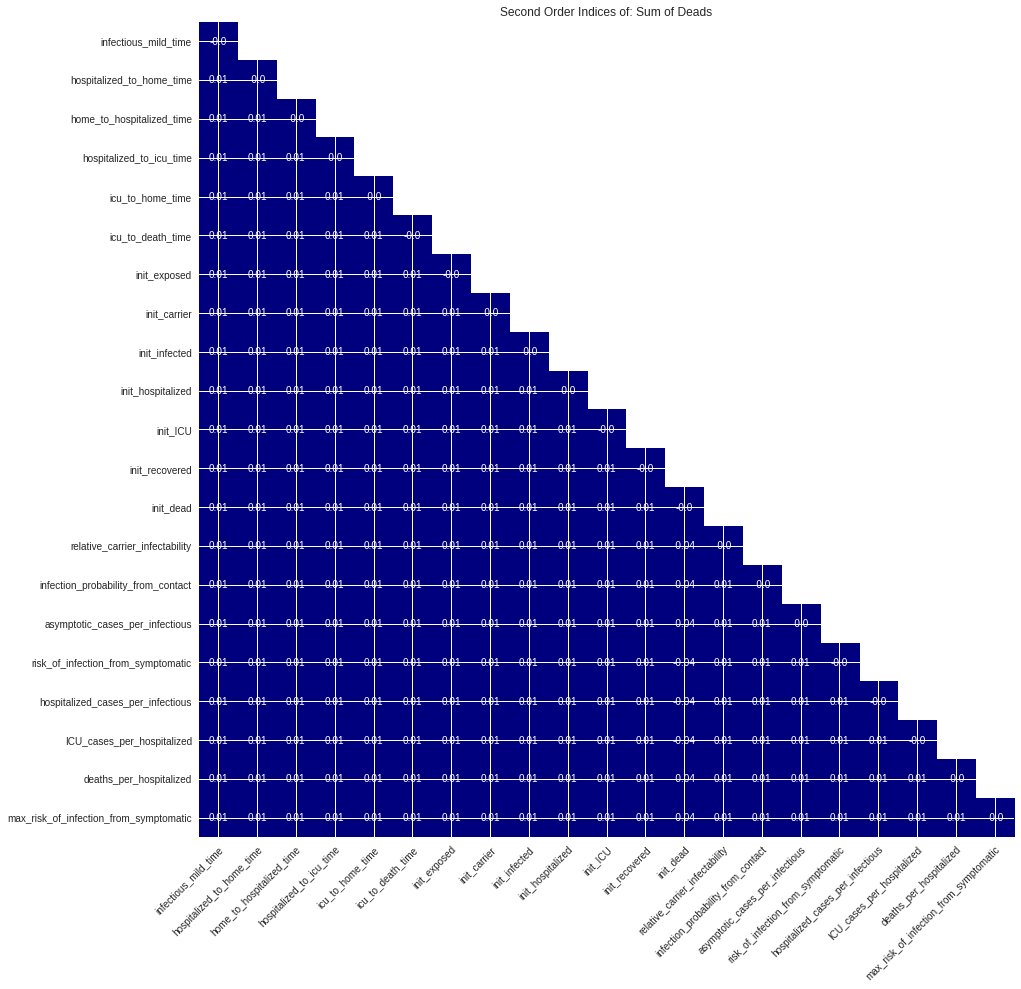

In [24]:
second_order = sensitivityAnalysis.getSecondOrderIndices()*(-1)
mask = np.ones_like(second_order)
mask[np.tril_indices_from(mask)] = False

f, ax = plt.subplots(figsize = (15,15))

masked_secondorder = np.ma.array(second_order, mask = mask)

cmap = cm.get_cmap('jet', 25)
cmap.set_bad('w')

im = ax.imshow(masked_secondorder, 
                #mask = mask, linewidth = 1, annot = True, 
                       #xticklabels = input_factor_names, yticklabels = input_factor_names, 
                vmin = 0, vmax = 1, cmap = cmap)


ax.set_xticks(np.arange(len(input_factor_names)))
ax.set_yticks(np.arange(len(input_factor_names)))

ax.set_xticklabels(input_factor_names)
ax.set_yticklabels(input_factor_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(len(input_factor_names)):
    for j in range(len(input_factor_names)):
        text = ax.text(j, i, np.round(second_order[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("Second Order Indices of: Sum of Deads")


plt.show()

# Scalar output results

In [ ]:
# create inputs

size = 1000

sie = ot.SobolIndicesExperiment(inputDistribution, size)

# generate samples from the input distribution
inputDesign = sie.generate()
print("Sample size: ", inputDesign.getSize())

In [ ]:
static_params["output_operation"]="max"

def dict_generate_output(inputDesign, input_factor_names = input_factor_names, static_params = static_params):
    # how many ooints does the integration return?
    # output = np.zeros((len(inputDesign), 70))
    output = []
    output = [simulate_model({**dict(zip(input_factor_names, sample)), **static_params}) for sample in inputDesign]
    
   
    return output

## Mean of infected

In [ ]:
static_params["output_operation"] = "mean"
static_params["output_index"] = [compartments.index("Infected")]

start = time.time()
outputDesign = ot.Sample(dict_generate_output(inputDesign))
end = time.time()
print(end - start)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1400, 500))

## Max of infected

In [ ]:
static_params["output_operation"] = "max"
static_params["output_index"] = [compartments.index("Infected")]

start = time.time()
outputDesign = ot.Sample(dict_generate_output(inputDesign))
end = time.time()
print(end - start)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1400, 500))

## Sum of infected

In [ ]:
static_params["output_operation"] = "sum"
static_params["output_index"] = [compartments.index("Infected")]

start = time.time()
outputDesign = ot.Sample(dict_generate_output(inputDesign))
end = time.time()
print(end - start)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1400, 500))

## Mean of hospitalized

In [ ]:
static_params["output_operation"] = "mean"
static_params["output_index"] = [compartments.index("Hospitalized")]

start = time.time()
outputDesign = ot.Sample(dict_generate_output(inputDesign))
end = time.time()
print(end - start)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1400, 500))

##  Max of hospitalized

In [ ]:
static_params["output_operation"] = "max"
static_params["output_index"] = [compartments.index("Hospitalized")]

start = time.time()
outputDesign = ot.Sample(dict_generate_output(inputDesign))
end = time.time()
print(end - start)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1400, 500))

## Sum of hospitalized

In [ ]:
static_params["output_operation"] = "sum"
static_params["output_index"] = [compartments.index("Hospitalized")]

start = time.time()
outputDesign = ot.Sample(dict_generate_output(inputDesign))
end = time.time()
print(end - start)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1400, 500))

## Mean of dead

In [ ]:
static_params["output_operation"] = "mean"
static_params["output_index"] = [compartments.index("Dead")]

start = time.time()
outputDesign = ot.Sample(dict_generate_output(inputDesign))
end = time.time()
print(end - start)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1400, 500))

## Max of dead

In [ ]:
static_params["output_operation"] = "max"
static_params["output_index"] = [compartments.index("Dead")]

start = time.time()
outputDesign = ot.Sample(dict_generate_output(inputDesign))
end = time.time()
print(end - start)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1400, 500))

## Sum of dead

In [ ]:
static_params["output_operation"] = "sum"
static_params["output_index"] = [compartments.index("Dead")]

start = time.time()
outputDesign = ot.Sample(dict_generate_output(inputDesign))
end = time.time()
print(end - start)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1400, 500))

In [ ]:
df_in = pd.DataFrame.from_records(inputDesign, columns = inputDesign.getDescription())
df_out = pd.DataFrame.from_records(outputDesign, columns = outputDesign.getDescription())
df_cobweb = pd.concat([df_in, df_out], axis = 1).sort_values(by=["v0"])
df_cobweb = df_cobweb.rename({"v0": "output"}, axis = 1)

In [ ]:
norm_df = (df_cobweb - df_cobweb.min())/(df_cobweb.max()-df_cobweb.min())
#norm_df = (df_cobweb - df_cobweb.mean())/(df_cobweb.std())

q = norm_df["output"].quantile(0.9)

def quantile_column(row, q = norm_df["output"].quantile(0.9)):
    if row['output'] > q:
        val = "above"
    else:
        val = "below"
    return val
norm_df["q90"]= norm_df.apply(quantile_column, axis = 1)


In [ ]:

plt.figure(figsize = (15, 6))
parallel_coordinates(norm_df, "q90", color=["grey", "orange"])
plt.xticks(rotation=90)
plt.show()

# Second Order indices of Sum of dead

In [ ]:
size = 1000
computeSecondOrder = True
sie = ot.SobolIndicesExperiment(inputDistribution, size, computeSecondOrder)
inputDesign = sie.generate()
print("Sample size: ", inputDesign.getSize())

static_params["output_operation"] = "sum"
static_params["output_index"] = [compartments.index("Dead")]

start = time.time()
outputDesign = ot.Sample(dict_generate_output(inputDesign))
end = time.time()
print(end - start)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

In [ ]:
second_order = sensitivityAnalysis.getSecondOrderIndices()
mask = np.ones_like(second_order)
mask[np.tril_indices_from(mask)] = False

f, ax = plt.subplots(figsize = (15,15))

masked_secondorder = np.ma.array(second_order, mask = mask)

cmap = cm.get_cmap('jet', 25)
cmap.set_bad('w')

im = ax.imshow(masked_secondorder, 
                #mask = mask, linewidth = 1, annot = True, 
                       #xticklabels = input_factor_names, yticklabels = input_factor_names, 
                vmin = 0, vmax = 1, cmap = cmap)


ax.set_xticks(np.arange(len(input_factor_names)))
ax.set_yticks(np.arange(len(input_factor_names)))

ax.set_xticklabels(input_factor_names)
ax.set_yticklabels(input_factor_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


for i in range(len(input_factor_names)):
    for j in range(len(input_factor_names)):
        text = ax.text(j, i, np.round(second_order[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("Second Order Indices of: Sum of Deads")


plt.show()

In [ ]:
# %prun dict_generate_output(inputDesign[:1000])

In [ ]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

In [ ]:
output_dimension = 1
for i in range(output_dimension):
    print("Output #", i)
    first_order = sensitivityAnalysis.getFirstOrderIndices(i)
    total_order = sensitivityAnalysis.getTotalOrderIndices(i)
    print("    First order indices: ", first_order)
    print("    Total order indices: ", total_order)

agg_first_order = sensitivityAnalysis.getAggregatedFirstOrderIndices()
agg_total_order = sensitivityAnalysis.getAggregatedTotalOrderIndices()
print("Agg. first order indices: ", agg_first_order)
print("Agg. total order indices: ", agg_total_order)

In [ ]:
graph = sensitivityAnalysis.draw()
view = viewer.View(graph, (1400, 500))

## Parallel Coordinate Plots

In [ ]:
minValue = 0.95
maxValue = 1.0
quantileScale = True
graphCobweb = ot.VisualTest.DrawCobWeb(inputDesign, outputDesign, minValue, maxValue, 'red', quantileScale)

In [ ]:
print(inputDesign.getDescription()[0])
print(inputDesign.getDescription()[2])
print(inputDesign.getDescription()[13])
print(inputDesign.getDescription()[15])

## Plotly 

In [ ]:
import plotly.express as px

In [ ]:
df_in = pd.DataFrame.from_records(inputDesign, columns = inputDesign.getDescription())
df_out = pd.DataFrame.from_records(outputDesign, columns = outputDesign.getDescription())
df_cobweb = pd.concat([df_in, df_out], axis = 1).sort_values(by=["v0"])
df_cobweb = df_cobweb.rename({"v0": "output"}, axis = 1)
df_cobweb.head()

In [ ]:
inputDesign.getDescription()

In [ ]:
short_names = ["inf mild", "hosp home", "home hosp", "hosp ICU", "ICU home", "ICU death", "ini exp", "ini car", "ini inf", "ini hosp", "ini ICU", "ini rec", "ini dead", "rel cinf", "inf cont", "asy per inf", "risk inf sy", "hosp / inf", "ICU / hosp", "death / hosp", "max risk sy", "out"]

long_names = list(inputDesign.getDescription())
long_names.append("output")
print(len(short_names), len(long_names))

In [ ]:
lens = dict(zip(long_names, short_names))
#lens

In [ ]:
fig = px.parallel_coordinates(df_cobweb, 
                             color_continuous_scale = px.colors.diverging.Tealrose,
                             labels = lens                      
                             )
fig.update_xaxes(tickangle = 45)
#fig.xticks(rotation=90)
fig.show()

## Pandas Parallel Coordinates

In [ ]:
from pandas.plotting import parallel_coordinates

In [ ]:
norm_df = (df_cobweb - df_cobweb.min())/(df_cobweb.max()-df_cobweb.min())
#norm_df = (df_cobweb - df_cobweb.mean())/(df_cobweb.std())

In [ ]:
norm_df = (df_cobweb - df_cobweb.min())/(df_cobweb.max()-df_cobweb.min())
#norm_df = (df_cobweb - df_cobweb.mean())/(df_cobweb.std())

q = norm_df["output"].quantile(0.9)

def quantile_column(row, q = norm_df["output"].quantile(0.9)):
    if row['output'] > q:
        val = "above"
    else:
        val = "below"
    return val
norm_df["q90"]= norm_df.apply(quantile_column, axis = 1)

plt.figure(figsize = (15, 6))
parallel_coordinates(norm_df, "q90", color=["grey", "orange"])
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize = (15, 6))
parallel_coordinates(norm_df, "q90", color=["grey", "orange"])
plt.xticks(rotation=90)
plt.show()

## Appendix

In [ ]:
#try itertuples

In [ ]:
df_inputDesign = pd.DataFrame.from_records(inputDesign, columns = inputDesign.getDescription())

In [ ]:
from utils_SA2 import simulate_model2

In [ ]:
def itertuples_df_generate_output(df):

    return list(simulate_model2(
        infectious_mild_time = row.infectious_mild_time,
        hospitalized_to_home_time = row.hospitalized_to_home_time,
        home_to_hospitalized_time = row.home_to_hospitalized_time,
        hospitalized_to_icu_time = row.hospitalized_to_icu_time,
        icu_to_home_time = row.icu_to_home_time,
        icu_to_death_time = row.icu_to_death_time,
        #
        init_exposed = row.init_exposed,
        init_carrier = row.init_carrier, 
        init_infected = row.init_infected, 
        init_hospitalized = row.init_hospitalized, 
        init_ICU = row.init_ICU, 
        init_recovered = row.init_recovered,
        init_dead = row.init_dead,
        #
        relative_carrier_infectability = row.relative_carrier_infectability, 
        infection_probability_from_contact = row.infection_probability_from_contact, 
        asymptotic_cases_per_infectious = row.asymptotic_cases_per_infectious, 
        risk_of_infection_from_symptomatic = row.risk_of_infection_from_symptomatic,
        hospitalized_cases_per_infectious = row.hospitalized_cases_per_infectious, 
        ICU_cases_per_hospitalized = row.ICU_cases_per_hospitalized,
        deaths_per_hospitalized = row.deaths_per_hospitalized, 
        max_risk_of_infection_from_symptomatic = row.max_risk_of_infection_from_symptomatic
    
    ) for row in df.itertuples())

In [ ]:
%timeit itertuples_df_generate_output(df_inputDesign.head(1000))

In [ ]:
%prun itertuples_df_generate_output(df_inputDesign[:1000])

In [ ]:
for a, b in zip(df_inputDesign["infectious_mild_time"], df_inputDesign["home_to_hospitalized_time"]):
    #print (a, b)

In [ ]:
# try list comprehension

def lcomp_df_generate_output(df):

    return list(simulate_model2( 
        infectious_mild_time = a,
        hospitalized_to_home_time = b,
        home_to_hospitalized_time = c,
        hospitalized_to_icu_time = c,
        icu_to_home_time = e,
        icu_to_death_time = f) for (a, b, c, d, e, f) in 
        zip(df["infectious_mild_time"], df["hospitalized_to_home_time"], 
            df["home_to_hospitalized_time"], df["hospitalized_to_icu_time"],
           df["icu_to_home_time"], df["icu_to_death_time"]))

In [ ]:
%timeit lcomp_df_generate_output(df_inputDesign[:1000])

In [ ]:
# try apply

def apply_df_generate_output(df):

    return df.apply(lambda row: simulate_model2(
        infectious_mild_time = row.infectious_mild_time,
        hospitalized_to_home_time = row.hospitalized_to_home_time,
        home_to_hospitalized_time = row.home_to_hospitalized_time,
        hospitalized_to_icu_time = row.hospitalized_to_icu_time,
        icu_to_home_time = row.icu_to_home_time,
        icu_to_death_time = row.icu_to_death_time,
        #
        init_exposed = row.init_exposed,
        init_carrier = row.init_carrier, 
        init_infected = row.init_infected, 
        init_hospitalized = row.init_hospitalized, 
        init_ICU = row.init_ICU, 
        init_recovered = row.init_recovered,
        init_dead = row.init_dead,
        #
        relative_carrier_infectability = row.relative_carrier_infectability, 
        infection_probability_from_contact = row.infection_probability_from_contact, 
        asymptotic_cases_per_infectious = row.asymptotic_cases_per_infectious, 
        risk_of_infection_from_symptomatic = row.risk_of_infection_from_symptomatic,
        hospitalized_cases_per_infectious = row.hospitalized_cases_per_infectious, 
        ICU_cases_per_hospitalized = row.ICU_cases_per_hospitalized,
        deaths_per_hospitalized = row.deaths_per_hospitalized, 
        max_risk_of_infection_from_symptomatic = row.max_risk_of_infection_from_symptomatic), 
                    axis = 1
    
)


In [ ]:
%timeit apply_df_generate_output(df_inputDesign[:1000])

In [ ]:
# try to replace values of default dict
default_params = {
    "infectious_mild_time" : 6.,
    "hospitalized_to_home_time" : 12.,
    "home_to_hospitalized_time" : 5.,
    "hospitalized_to_icu_time" : 2.,
    "icu_to_home_time" : 8.,
    "icu_to_death_time" : 5.,
    #
    "init_exposed" : 100,
    "init_carrier" : 50, 
    "init_infected" : 20, 
    "init_hospitalized" : 20, 
    "init_ICU" : 10, 
    "init_recovered" : 10,
    "init_dead" : 0,
    #
    "relative_carrier_infectability" : 0.67, 
    "infection_probability_from_contact" : 1.0, 
    "asymptotic_cases_per_infectious" : 0.09, 
    "risk_of_infection_from_symptomatic" : 0.25,
    "hospitalized_cases_per_infectious" : 0.2, 
    "ICU_cases_per_hospitalized" : 0.25,
    "deaths_per_hospitalized" : 0.3, 
    "max_risk_of_infection_from_symptomatic" : 0.5,
    #
    "num_groups" : num_groups, 
    "num_compartments" : num_compartments,
    "populations" : populations,
    "start_day" : starting_day,
    "baseline_contact_matrix" : baseline_contact_matrix, 
    "minimum_contact_matrix" : minimum_contact_matrix,
    "damping_coeff" : 0.9, 
    "days" : days,
    "dt" : dt,
    "output_index" : compartments.index("Infected")  
}

In [ ]:
# try map
def map_df_generate_output(df):

    return list(map(simulate_model2,
        df["infectious_mild_time"],
        hospitalized_to_home_time = row.hospitalized_to_home_time,
        home_to_hospitalized_time = row.home_to_hospitalized_time,
        hospitalized_to_icu_time = row.hospitalized_to_icu_time,
        icu_to_home_time = row.icu_to_home_time,
        icu_to_death_time = row.icu_to_death_time) for par in zip(df[]))

In [ ]:
from collections import namedtuple

In [ ]:
df_static_params = pd.DataFrame({
    'num_groups': [num_groups], 
    'num_compartments': [num_compartments],
    'populations': [populations],
    'start_day' : [(date(start_year, start_month, start_day) - date(start_year, 1, 1)).days],
    'baseline_contact_matrix' : [baseline_contact_matrix], 
    'minimum_contact_matrix' : [minimum_contact_matrix],
    'damping_coeff' : [0.9], 
    'days' : [days],
    'dt' : [dt],
    # which compartment's maximal value should be outputed?
    'output_index' : [compartments.index("Infected")]
    } 
)

In [ ]:
# num_groups
# num_compartments
# start_date = (date(start_year, start_month, start_day) - date(start_year, 1, 1)).days
# baseline_contact_matrix = baseline_contact_matrix, 
# minimum_contact_matrix = minimum_contact_matrix
# damping_coeff
# damping_time
# damping_level
# daming_type
# days
# dt
# output_index = compartments.index("Infected") -> hard coded